# Integration and label transfer with Tabula Muris

Following the general tutorial on atlas-level integration, here we show using scVI and scANVI for label transfer. In this setting we have:

1. Fully-labeled reference dataset
1. Unlabeled query dataset

We will demonstrate this functionality using Tabula Muris:

- Tabula Muris Consortium. "Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris." Nature 562.7727 (2018): 367-372.

It is important to note that this tutorial covers *de novo* integration. With scvi-tools you can also perform online or sequential integration (i.e., *reference mapping*). Please see the scArches tutorial for more details.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model.utils import mde

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We supply Scanpy's read function with a backup url, which covers automatic data download.

In [5]:
tm_droplet_path = os.path.join(save_dir.name, "TM_droplet.h5ad")
tm_facs_path = os.path.join(save_dir.name, "TM_facs.h5ad")

tm_droplet = sc.read(
    tm_droplet_path,
    backup_url="https://figshare.com/ndownloader/files/23938934",
)
tm_facs = sc.read(
    tm_facs_path,
    backup_url="https://figshare.com/ndownloader/files/23939711",
)

  0%|          | 0.00/3.78G [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


  0%|          | 0.00/2.20G [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


We subset to labelled bone marrow cells from female mice because it is a reasonably sized dataset that will allow us to validate our method's ability to transfer labels from one dataset to another. In Tabula Muris, we are provided data collected using 10x Chromium, as well as SmartSeq2 data.

In [6]:
tm_droplet = tm_droplet[
    (tm_droplet.obs.tissue == "Marrow")
    & (~tm_droplet.obs.cell_ontology_class.isna())
    & (tm_droplet.obs.sex == "female")
].copy()
tm_facs = tm_facs[
    (tm_facs.obs.tissue == "Marrow")
    & (~tm_facs.obs.cell_ontology_class.isna())
    & (tm_facs.obs.sex == "female")
].copy()

tm_droplet.obs["tech"] = "10x"
tm_facs.obs["tech"] = "SS2"

In [7]:
tm_droplet.shape, tm_facs.shape

((11707, 20138), (4200, 22966))

## Dataset preprocessing

### Normalize Smartseq2 matrix by gene length

We apply gene-length normalization because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMIs are used (as in 10x). A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B.
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data.

The gene length file here is computed by taking the average length of alal transcripts corresponding to a mouse gene recorded in the ensembl dataabase.

In [8]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [9]:
gene_len = gene_len.reindex(tm_facs.var.index).dropna()
tm_facs = tm_facs[:, gene_len.index]
assert (tm_facs.var.index == gene_len.index).sum() == tm_facs.shape[1]
tm_facs.X = tm_facs.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
tm_facs.X = np.rint(tm_facs.X)

### Dataset concatenation and gene selection

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the Scanpy pipeline while keeping the raw data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections via the Scanpy function.

In [10]:
adata = anndata.concat([tm_droplet, tm_facs])
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="tech",
    subset=True,
)

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample.
- Create an SCVI model object.

In [11]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [12]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

Now we train scVI. This should take a couple of minutes on a Colab session

In [13]:
scvi_model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:01<07:22,  1.11s/it]

Epoch 1/400:   0%|          | 1/400 [00:01<07:22,  1.11s/it, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.59e+3]

Epoch 2/400:   0%|          | 1/400 [00:01<07:22,  1.11s/it, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.59e+3]

Epoch 2/400:   0%|          | 2/400 [00:01<05:12,  1.27it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.59e+3]

Epoch 2/400:   0%|          | 2/400 [00:01<05:12,  1.27it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.24e+3]

Epoch 3/400:   0%|          | 2/400 [00:01<05:12,  1.27it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.24e+3]

Epoch 3/400:   1%|          | 3/400 [00:02<04:30,  1.47it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.24e+3]

Epoch 3/400:   1%|          | 3/400 [00:02<04:30,  1.47it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3] 

Epoch 4/400:   1%|          | 3/400 [00:02<04:30,  1.47it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 4/400:   1%|          | 4/400 [00:02<04:09,  1.59it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 4/400:   1%|          | 4/400 [00:02<04:09,  1.59it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.17e+3]

Epoch 5/400:   1%|          | 4/400 [00:02<04:09,  1.59it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.17e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:03<03:58,  1.66it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.17e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:03<03:58,  1.66it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.15e+3]

Epoch 6/400:   1%|▏         | 5/400 [00:03<03:58,  1.66it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.15e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.15e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.14e+3]

Epoch 7/400:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.14e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:04<03:46,  1.73it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.14e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:04<03:46,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]

Epoch 8/400:   2%|▏         | 7/400 [00:04<03:46,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:04<03:43,  1.75it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.13e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:04<03:43,  1.75it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3] 

Epoch 9/400:   2%|▏         | 8/400 [00:05<03:43,  1.75it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:05<03:41,  1.77it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.12e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:05<03:41,  1.77it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

Epoch 10/400:   2%|▏         | 9/400 [00:05<03:41,  1.77it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:06<03:39,  1.78it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.12e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:06<03:39,  1.78it/s, v_num=1, train_loss_step=993, train_loss_epoch=1.11e+3]    

Epoch 11/400:   2%|▎         | 10/400 [00:06<03:39,  1.78it/s, v_num=1, train_loss_step=993, train_loss_epoch=1.11e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:06<03:38,  1.78it/s, v_num=1, train_loss_step=993, train_loss_epoch=1.11e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:06<03:38,  1.78it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.11e+3]

Epoch 12/400:   3%|▎         | 11/400 [00:06<03:38,  1.78it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.11e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:07<03:37,  1.79it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.11e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:07<03:37,  1.79it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.1e+3] 

Epoch 13/400:   3%|▎         | 12/400 [00:07<03:37,  1.79it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.1e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:07<03:36,  1.79it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.1e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:07<03:36,  1.79it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.1e+3]

Epoch 14/400:   3%|▎         | 13/400 [00:07<03:36,  1.79it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.1e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:08<03:35,  1.79it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.1e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:08<03:35,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.09e+3]

Epoch 15/400:   4%|▎         | 14/400 [00:08<03:35,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.09e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:08<03:34,  1.80it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.09e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:08<03:34,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.09e+3]

Epoch 16/400:   4%|▍         | 15/400 [00:08<03:34,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.09e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:09<03:33,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.09e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:09<03:33,  1.80it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.09e+3]   

Epoch 17/400:   4%|▍         | 16/400 [00:09<03:33,  1.80it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.09e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:10<03:33,  1.80it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.09e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:10<03:33,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.09e+3]

Epoch 18/400:   4%|▍         | 17/400 [00:10<03:33,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.09e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:10<03:33,  1.79it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.09e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:10<03:33,  1.79it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 19/400:   4%|▍         | 18/400 [00:10<03:33,  1.79it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:11<03:34,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:11<03:34,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 20/400:   5%|▍         | 19/400 [00:11<03:34,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 20/400:   5%|▌         | 20/400 [00:11<03:35,  1.77it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.08e+3]

Epoch 20/400:   5%|▌         | 20/400 [00:11<03:35,  1.77it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.08e+3]

Epoch 21/400:   5%|▌         | 20/400 [00:11<03:35,  1.77it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.08e+3]

Epoch 21/400:   5%|▌         | 21/400 [00:12<03:35,  1.76it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.08e+3]

Epoch 21/400:   5%|▌         | 21/400 [00:12<03:35,  1.76it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.08e+3]

Epoch 22/400:   5%|▌         | 21/400 [00:12<03:35,  1.76it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.08e+3]

Epoch 22/400:   6%|▌         | 22/400 [00:12<03:37,  1.74it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.08e+3]

Epoch 22/400:   6%|▌         | 22/400 [00:12<03:37,  1.74it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.08e+3]

Epoch 23/400:   6%|▌         | 22/400 [00:12<03:37,  1.74it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.08e+3]

Epoch 23/400:   6%|▌         | 23/400 [00:13<03:38,  1.73it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.08e+3]

Epoch 23/400:   6%|▌         | 23/400 [00:13<03:38,  1.73it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 24/400:   6%|▌         | 23/400 [00:13<03:38,  1.73it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 24/400:   6%|▌         | 24/400 [00:14<03:36,  1.74it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.07e+3]

Epoch 24/400:   6%|▌         | 24/400 [00:14<03:36,  1.74it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.07e+3]

Epoch 25/400:   6%|▌         | 24/400 [00:14<03:36,  1.74it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.07e+3]

Epoch 25/400:   6%|▋         | 25/400 [00:14<03:36,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.07e+3]

Epoch 25/400:   6%|▋         | 25/400 [00:14<03:36,  1.73it/s, v_num=1, train_loss_step=886, train_loss_epoch=1.07e+3]    

Epoch 26/400:   6%|▋         | 25/400 [00:14<03:36,  1.73it/s, v_num=1, train_loss_step=886, train_loss_epoch=1.07e+3]

Epoch 26/400:   6%|▋         | 26/400 [00:15<03:34,  1.74it/s, v_num=1, train_loss_step=886, train_loss_epoch=1.07e+3]

Epoch 26/400:   6%|▋         | 26/400 [00:15<03:34,  1.74it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.07e+3]

Epoch 27/400:   6%|▋         | 26/400 [00:15<03:34,  1.74it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.07e+3]

Epoch 27/400:   7%|▋         | 27/400 [00:15<03:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.07e+3]

Epoch 27/400:   7%|▋         | 27/400 [00:15<03:35,  1.73it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.07e+3]

Epoch 28/400:   7%|▋         | 27/400 [00:15<03:35,  1.73it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.07e+3]

Epoch 28/400:   7%|▋         | 28/400 [00:16<03:34,  1.74it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.07e+3]

Epoch 28/400:   7%|▋         | 28/400 [00:16<03:34,  1.74it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.07e+3]

Epoch 29/400:   7%|▋         | 28/400 [00:16<03:34,  1.74it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.07e+3]

Epoch 29/400:   7%|▋         | 29/400 [00:16<03:32,  1.75it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.07e+3]

Epoch 29/400:   7%|▋         | 29/400 [00:16<03:32,  1.75it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 30/400:   7%|▋         | 29/400 [00:16<03:32,  1.75it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 30/400:   8%|▊         | 30/400 [00:17<03:30,  1.76it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.07e+3]

Epoch 30/400:   8%|▊         | 30/400 [00:17<03:30,  1.76it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 31/400:   8%|▊         | 30/400 [00:17<03:30,  1.76it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 31/400:   8%|▊         | 31/400 [00:18<03:28,  1.77it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 31/400:   8%|▊         | 31/400 [00:18<03:28,  1.77it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 32/400:   8%|▊         | 31/400 [00:18<03:28,  1.77it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 32/400:   8%|▊         | 32/400 [00:18<03:27,  1.77it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.07e+3]

Epoch 32/400:   8%|▊         | 32/400 [00:18<03:27,  1.77it/s, v_num=1, train_loss_step=862, train_loss_epoch=1.06e+3]    

Epoch 33/400:   8%|▊         | 32/400 [00:18<03:27,  1.77it/s, v_num=1, train_loss_step=862, train_loss_epoch=1.06e+3]

Epoch 33/400:   8%|▊         | 33/400 [00:19<03:26,  1.78it/s, v_num=1, train_loss_step=862, train_loss_epoch=1.06e+3]

Epoch 33/400:   8%|▊         | 33/400 [00:19<03:26,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 34/400:   8%|▊         | 33/400 [00:19<03:26,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 34/400:   8%|▊         | 34/400 [00:19<03:25,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 34/400:   8%|▊         | 34/400 [00:19<03:25,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 35/400:   8%|▊         | 34/400 [00:19<03:25,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 35/400:   9%|▉         | 35/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 35/400:   9%|▉         | 35/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 36/400:   9%|▉         | 35/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 36/400:   9%|▉         | 36/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.06e+3]

Epoch 36/400:   9%|▉         | 36/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 37/400:   9%|▉         | 36/400 [00:20<03:24,  1.78it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 37/400:   9%|▉         | 37/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.06e+3]

Epoch 37/400:   9%|▉         | 37/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 38/400:   9%|▉         | 37/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 38/400:  10%|▉         | 38/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 38/400:  10%|▉         | 38/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.06e+3]

Epoch 39/400:  10%|▉         | 38/400 [00:21<03:23,  1.78it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.06e+3]

Epoch 39/400:  10%|▉         | 39/400 [00:22<03:22,  1.78it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.06e+3]

Epoch 39/400:  10%|▉         | 39/400 [00:22<03:22,  1.78it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3] 

Epoch 40/400:  10%|▉         | 39/400 [00:22<03:22,  1.78it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 40/400:  10%|█         | 40/400 [00:23<03:21,  1.78it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

Epoch 40/400:  10%|█         | 40/400 [00:23<03:21,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 41/400:  10%|█         | 40/400 [00:23<03:21,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 41/400:  10%|█         | 41/400 [00:23<03:25,  1.75it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 41/400:  10%|█         | 41/400 [00:23<03:25,  1.75it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 42/400:  10%|█         | 41/400 [00:23<03:25,  1.75it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 42/400:  10%|█         | 42/400 [00:24<03:25,  1.74it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 42/400:  10%|█         | 42/400 [00:24<03:25,  1.74it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 43/400:  10%|█         | 42/400 [00:24<03:25,  1.74it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 43/400:  11%|█         | 43/400 [00:24<03:22,  1.76it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.06e+3]

Epoch 43/400:  11%|█         | 43/400 [00:24<03:22,  1.76it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 44/400:  11%|█         | 43/400 [00:24<03:22,  1.76it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 44/400:  11%|█         | 44/400 [00:25<03:20,  1.77it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.06e+3]

Epoch 44/400:  11%|█         | 44/400 [00:25<03:20,  1.77it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 45/400:  11%|█         | 44/400 [00:25<03:20,  1.77it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 45/400:  11%|█▏        | 45/400 [00:25<03:18,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 45/400:  11%|█▏        | 45/400 [00:25<03:18,  1.79it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 46/400:  11%|█▏        | 45/400 [00:25<03:18,  1.79it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 46/400:  12%|█▏        | 46/400 [00:26<03:17,  1.79it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.06e+3]

Epoch 46/400:  12%|█▏        | 46/400 [00:26<03:17,  1.79it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 47/400:  12%|█▏        | 46/400 [00:26<03:17,  1.79it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 47/400:  12%|█▏        | 47/400 [00:27<03:16,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.06e+3]

Epoch 47/400:  12%|█▏        | 47/400 [00:27<03:16,  1.80it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 48/400:  12%|█▏        | 47/400 [00:27<03:16,  1.80it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 48/400:  12%|█▏        | 48/400 [00:27<03:15,  1.81it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.06e+3]

Epoch 48/400:  12%|█▏        | 48/400 [00:27<03:15,  1.81it/s, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]    

Epoch 49/400:  12%|█▏        | 48/400 [00:27<03:15,  1.81it/s, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]

Epoch 49/400:  12%|█▏        | 49/400 [00:28<03:14,  1.81it/s, v_num=1, train_loss_step=999, train_loss_epoch=1.06e+3]

Epoch 49/400:  12%|█▏        | 49/400 [00:28<03:14,  1.81it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.06e+3]

Epoch 50/400:  12%|█▏        | 49/400 [00:28<03:14,  1.81it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.06e+3]

Epoch 50/400:  12%|█▎        | 50/400 [00:28<03:13,  1.81it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.06e+3]

Epoch 50/400:  12%|█▎        | 50/400 [00:28<03:13,  1.81it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 51/400:  12%|█▎        | 50/400 [00:28<03:13,  1.81it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 51/400:  13%|█▎        | 51/400 [00:29<03:12,  1.81it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 51/400:  13%|█▎        | 51/400 [00:29<03:12,  1.81it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]  

Epoch 52/400:  13%|█▎        | 51/400 [00:29<03:12,  1.81it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 52/400:  13%|█▎        | 52/400 [00:29<03:11,  1.81it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 52/400:  13%|█▎        | 52/400 [00:29<03:11,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 53/400:  13%|█▎        | 52/400 [00:29<03:11,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 53/400:  13%|█▎        | 53/400 [00:30<03:11,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 53/400:  13%|█▎        | 53/400 [00:30<03:11,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 54/400:  13%|█▎        | 53/400 [00:30<03:11,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 54/400:  14%|█▎        | 54/400 [00:30<03:10,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 54/400:  14%|█▎        | 54/400 [00:30<03:10,  1.81it/s, v_num=1, train_loss_step=888, train_loss_epoch=1.05e+3]    

Epoch 55/400:  14%|█▎        | 54/400 [00:30<03:10,  1.81it/s, v_num=1, train_loss_step=888, train_loss_epoch=1.05e+3]

Epoch 55/400:  14%|█▍        | 55/400 [00:31<03:10,  1.81it/s, v_num=1, train_loss_step=888, train_loss_epoch=1.05e+3]

Epoch 55/400:  14%|█▍        | 55/400 [00:31<03:10,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 56/400:  14%|█▍        | 55/400 [00:31<03:10,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 56/400:  14%|█▍        | 56/400 [00:31<03:09,  1.82it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 56/400:  14%|█▍        | 56/400 [00:31<03:09,  1.82it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.05e+3]

Epoch 57/400:  14%|█▍        | 56/400 [00:31<03:09,  1.82it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.05e+3]

Epoch 57/400:  14%|█▍        | 57/400 [00:32<03:08,  1.82it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.05e+3]

Epoch 57/400:  14%|█▍        | 57/400 [00:32<03:08,  1.82it/s, v_num=1, train_loss_step=981, train_loss_epoch=1.05e+3]    

Epoch 58/400:  14%|█▍        | 57/400 [00:32<03:08,  1.82it/s, v_num=1, train_loss_step=981, train_loss_epoch=1.05e+3]

Epoch 58/400:  14%|█▍        | 58/400 [00:33<03:08,  1.82it/s, v_num=1, train_loss_step=981, train_loss_epoch=1.05e+3]

Epoch 58/400:  14%|█▍        | 58/400 [00:33<03:08,  1.82it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]

Epoch 59/400:  14%|█▍        | 58/400 [00:33<03:08,  1.82it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]

Epoch 59/400:  15%|█▍        | 59/400 [00:33<03:07,  1.82it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]

Epoch 59/400:  15%|█▍        | 59/400 [00:33<03:07,  1.82it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 60/400:  15%|█▍        | 59/400 [00:33<03:07,  1.82it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 60/400:  15%|█▌        | 60/400 [00:34<03:07,  1.82it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 60/400:  15%|█▌        | 60/400 [00:34<03:07,  1.82it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 61/400:  15%|█▌        | 60/400 [00:34<03:07,  1.82it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 61/400:  15%|█▌        | 61/400 [00:34<03:06,  1.82it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 61/400:  15%|█▌        | 61/400 [00:34<03:06,  1.82it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 62/400:  15%|█▌        | 61/400 [00:34<03:06,  1.82it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 62/400:  16%|█▌        | 62/400 [00:35<03:06,  1.82it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 62/400:  16%|█▌        | 62/400 [00:35<03:06,  1.82it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]   

Epoch 63/400:  16%|█▌        | 62/400 [00:35<03:06,  1.82it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]

Epoch 63/400:  16%|█▌        | 63/400 [00:35<03:06,  1.80it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]

Epoch 63/400:  16%|█▌        | 63/400 [00:35<03:06,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 64/400:  16%|█▌        | 63/400 [00:35<03:06,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 64/400:  16%|█▌        | 64/400 [00:36<03:06,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 64/400:  16%|█▌        | 64/400 [00:36<03:06,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 65/400:  16%|█▌        | 64/400 [00:36<03:06,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 65/400:  16%|█▋        | 65/400 [00:36<03:05,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 65/400:  16%|█▋        | 65/400 [00:36<03:05,  1.80it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 66/400:  16%|█▋        | 65/400 [00:36<03:05,  1.80it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 66/400:  16%|█▋        | 66/400 [00:37<03:05,  1.81it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 66/400:  16%|█▋        | 66/400 [00:37<03:05,  1.81it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 67/400:  16%|█▋        | 66/400 [00:37<03:05,  1.81it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 67/400:  17%|█▋        | 67/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 67/400:  17%|█▋        | 67/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 68/400:  17%|█▋        | 67/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 68/400:  17%|█▋        | 68/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 68/400:  17%|█▋        | 68/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 69/400:  17%|█▋        | 68/400 [00:38<03:04,  1.80it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 69/400:  17%|█▋        | 69/400 [00:39<03:03,  1.80it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 69/400:  17%|█▋        | 69/400 [00:39<03:03,  1.80it/s, v_num=1, train_loss_step=986, train_loss_epoch=1.05e+3]    

Epoch 70/400:  17%|█▋        | 69/400 [00:39<03:03,  1.80it/s, v_num=1, train_loss_step=986, train_loss_epoch=1.05e+3]

Epoch 70/400:  18%|█▊        | 70/400 [00:39<03:02,  1.80it/s, v_num=1, train_loss_step=986, train_loss_epoch=1.05e+3]

Epoch 70/400:  18%|█▊        | 70/400 [00:39<03:02,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 71/400:  18%|█▊        | 70/400 [00:39<03:02,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 71/400:  18%|█▊        | 71/400 [00:40<03:02,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 71/400:  18%|█▊        | 71/400 [00:40<03:02,  1.80it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]    

Epoch 72/400:  18%|█▊        | 71/400 [00:40<03:02,  1.80it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 72/400:  18%|█▊        | 72/400 [00:40<03:01,  1.81it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 72/400:  18%|█▊        | 72/400 [00:40<03:01,  1.81it/s, v_num=1, train_loss_step=925, train_loss_epoch=1.05e+3]

Epoch 73/400:  18%|█▊        | 72/400 [00:40<03:01,  1.81it/s, v_num=1, train_loss_step=925, train_loss_epoch=1.05e+3]

Epoch 73/400:  18%|█▊        | 73/400 [00:41<03:00,  1.81it/s, v_num=1, train_loss_step=925, train_loss_epoch=1.05e+3]

Epoch 73/400:  18%|█▊        | 73/400 [00:41<03:00,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 74/400:  18%|█▊        | 73/400 [00:41<03:00,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 74/400:  18%|█▊        | 74/400 [00:41<03:00,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 74/400:  18%|█▊        | 74/400 [00:41<03:00,  1.80it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 75/400:  18%|█▊        | 74/400 [00:41<03:00,  1.80it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 75/400:  19%|█▉        | 75/400 [00:42<03:00,  1.80it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 75/400:  19%|█▉        | 75/400 [00:42<03:00,  1.80it/s, v_num=1, train_loss_step=899, train_loss_epoch=1.05e+3]    

Epoch 76/400:  19%|█▉        | 75/400 [00:42<03:00,  1.80it/s, v_num=1, train_loss_step=899, train_loss_epoch=1.05e+3]

Epoch 76/400:  19%|█▉        | 76/400 [00:43<02:59,  1.80it/s, v_num=1, train_loss_step=899, train_loss_epoch=1.05e+3]

Epoch 76/400:  19%|█▉        | 76/400 [00:43<02:59,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 77/400:  19%|█▉        | 76/400 [00:43<02:59,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 77/400:  19%|█▉        | 77/400 [00:43<02:58,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 77/400:  19%|█▉        | 77/400 [00:43<02:58,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 78/400:  19%|█▉        | 77/400 [00:43<02:58,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 78/400:  20%|█▉        | 78/400 [00:44<02:58,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 78/400:  20%|█▉        | 78/400 [00:44<02:58,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 79/400:  20%|█▉        | 78/400 [00:44<02:58,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 79/400:  20%|█▉        | 79/400 [00:44<02:57,  1.81it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 79/400:  20%|█▉        | 79/400 [00:44<02:57,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 80/400:  20%|█▉        | 79/400 [00:44<02:57,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 80/400:  20%|██        | 80/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 80/400:  20%|██        | 80/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 81/400:  20%|██        | 80/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 81/400:  20%|██        | 81/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 81/400:  20%|██        | 81/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 82/400:  20%|██        | 81/400 [00:45<02:56,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 82/400:  20%|██        | 82/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 82/400:  20%|██        | 82/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 83/400:  20%|██        | 82/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 83/400:  21%|██        | 83/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 83/400:  21%|██        | 83/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 84/400:  21%|██        | 83/400 [00:46<02:55,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 84/400:  21%|██        | 84/400 [00:47<02:54,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 84/400:  21%|██        | 84/400 [00:47<02:54,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 85/400:  21%|██        | 84/400 [00:47<02:54,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 85/400:  21%|██▏       | 85/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 85/400:  21%|██▏       | 85/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 86/400:  21%|██▏       | 85/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 86/400:  22%|██▏       | 86/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 86/400:  22%|██▏       | 86/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]    

Epoch 87/400:  22%|██▏       | 86/400 [00:48<02:53,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]

Epoch 87/400:  22%|██▏       | 87/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]

Epoch 87/400:  22%|██▏       | 87/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 88/400:  22%|██▏       | 87/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 88/400:  22%|██▏       | 88/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 88/400:  22%|██▏       | 88/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]    

Epoch 89/400:  22%|██▏       | 88/400 [00:49<02:52,  1.81it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]

Epoch 89/400:  22%|██▏       | 89/400 [00:50<02:51,  1.81it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]

Epoch 89/400:  22%|██▏       | 89/400 [00:50<02:51,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 90/400:  22%|██▏       | 89/400 [00:50<02:51,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 90/400:  22%|██▎       | 90/400 [00:50<02:50,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 90/400:  22%|██▎       | 90/400 [00:50<02:50,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 91/400:  22%|██▎       | 90/400 [00:50<02:50,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 91/400:  23%|██▎       | 91/400 [00:51<02:50,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 91/400:  23%|██▎       | 91/400 [00:51<02:50,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 92/400:  23%|██▎       | 91/400 [00:51<02:50,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 92/400:  23%|██▎       | 92/400 [00:51<02:50,  1.80it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 92/400:  23%|██▎       | 92/400 [00:51<02:50,  1.80it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 93/400:  23%|██▎       | 92/400 [00:51<02:50,  1.80it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 93/400:  23%|██▎       | 93/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 93/400:  23%|██▎       | 93/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 94/400:  23%|██▎       | 93/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 94/400:  24%|██▎       | 94/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 94/400:  24%|██▎       | 94/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=884, train_loss_epoch=1.05e+3]    

Epoch 95/400:  24%|██▎       | 94/400 [00:52<02:50,  1.80it/s, v_num=1, train_loss_step=884, train_loss_epoch=1.05e+3]

Epoch 95/400:  24%|██▍       | 95/400 [00:53<02:49,  1.80it/s, v_num=1, train_loss_step=884, train_loss_epoch=1.05e+3]

Epoch 95/400:  24%|██▍       | 95/400 [00:53<02:49,  1.80it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 96/400:  24%|██▍       | 95/400 [00:53<02:49,  1.80it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 96/400:  24%|██▍       | 96/400 [00:54<02:49,  1.80it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 96/400:  24%|██▍       | 96/400 [00:54<02:49,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 97/400:  24%|██▍       | 96/400 [00:54<02:49,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 97/400:  24%|██▍       | 97/400 [00:54<02:48,  1.80it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 97/400:  24%|██▍       | 97/400 [00:54<02:48,  1.80it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]    

Epoch 98/400:  24%|██▍       | 97/400 [00:54<02:48,  1.80it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 98/400:  24%|██▍       | 98/400 [00:55<02:48,  1.80it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 98/400:  24%|██▍       | 98/400 [00:55<02:48,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 99/400:  24%|██▍       | 98/400 [00:55<02:48,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 99/400:  25%|██▍       | 99/400 [00:55<02:47,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 99/400:  25%|██▍       | 99/400 [00:55<02:47,  1.80it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 100/400:  25%|██▍       | 99/400 [00:55<02:47,  1.80it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 100/400:  25%|██▌       | 100/400 [00:56<02:47,  1.80it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 100/400:  25%|██▌       | 100/400 [00:56<02:47,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 101/400:  25%|██▌       | 100/400 [00:56<02:47,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 101/400:  25%|██▌       | 101/400 [00:56<02:46,  1.80it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 101/400:  25%|██▌       | 101/400 [00:56<02:46,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 102/400:  25%|██▌       | 101/400 [00:56<02:46,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 102/400:  26%|██▌       | 102/400 [00:57<02:46,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 102/400:  26%|██▌       | 102/400 [00:57<02:46,  1.80it/s, v_num=1, train_loss_step=960, train_loss_epoch=1.05e+3]    

Epoch 103/400:  26%|██▌       | 102/400 [00:57<02:46,  1.80it/s, v_num=1, train_loss_step=960, train_loss_epoch=1.05e+3]

Epoch 103/400:  26%|██▌       | 103/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=960, train_loss_epoch=1.05e+3]

Epoch 103/400:  26%|██▌       | 103/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 104/400:  26%|██▌       | 103/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 104/400:  26%|██▌       | 104/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 104/400:  26%|██▌       | 104/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 105/400:  26%|██▌       | 104/400 [00:58<02:45,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 105/400:  26%|██▋       | 105/400 [00:59<02:44,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 105/400:  26%|██▋       | 105/400 [00:59<02:44,  1.79it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]    

Epoch 106/400:  26%|██▋       | 105/400 [00:59<02:44,  1.79it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]

Epoch 106/400:  26%|██▋       | 106/400 [00:59<02:43,  1.79it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]

Epoch 106/400:  26%|██▋       | 106/400 [00:59<02:43,  1.79it/s, v_num=1, train_loss_step=975, train_loss_epoch=1.05e+3]

Epoch 107/400:  26%|██▋       | 106/400 [00:59<02:43,  1.79it/s, v_num=1, train_loss_step=975, train_loss_epoch=1.05e+3]

Epoch 107/400:  27%|██▋       | 107/400 [01:00<02:43,  1.79it/s, v_num=1, train_loss_step=975, train_loss_epoch=1.05e+3]

Epoch 107/400:  27%|██▋       | 107/400 [01:00<02:43,  1.79it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 108/400:  27%|██▋       | 107/400 [01:00<02:43,  1.79it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 108/400:  27%|██▋       | 108/400 [01:00<02:42,  1.79it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 108/400:  27%|██▋       | 108/400 [01:00<02:42,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 109/400:  27%|██▋       | 108/400 [01:00<02:42,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 109/400:  27%|██▋       | 109/400 [01:01<02:42,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 109/400:  27%|██▋       | 109/400 [01:01<02:42,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 110/400:  27%|██▋       | 109/400 [01:01<02:42,  1.79it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 110/400:  28%|██▊       | 110/400 [01:01<02:42,  1.78it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 110/400:  28%|██▊       | 110/400 [01:01<02:42,  1.78it/s, v_num=1, train_loss_step=957, train_loss_epoch=1.05e+3]    

Epoch 111/400:  28%|██▊       | 110/400 [01:01<02:42,  1.78it/s, v_num=1, train_loss_step=957, train_loss_epoch=1.05e+3]

Epoch 111/400:  28%|██▊       | 111/400 [01:02<02:43,  1.77it/s, v_num=1, train_loss_step=957, train_loss_epoch=1.05e+3]

Epoch 111/400:  28%|██▊       | 111/400 [01:02<02:43,  1.77it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 112/400:  28%|██▊       | 111/400 [01:02<02:43,  1.77it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 112/400:  28%|██▊       | 112/400 [01:03<02:43,  1.76it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 112/400:  28%|██▊       | 112/400 [01:03<02:43,  1.76it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 113/400:  28%|██▊       | 112/400 [01:03<02:43,  1.76it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 113/400:  28%|██▊       | 113/400 [01:03<02:45,  1.74it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 113/400:  28%|██▊       | 113/400 [01:03<02:45,  1.74it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 114/400:  28%|██▊       | 113/400 [01:03<02:45,  1.74it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 114/400:  28%|██▊       | 114/400 [01:04<02:45,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 114/400:  28%|██▊       | 114/400 [01:04<02:45,  1.73it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 115/400:  28%|██▊       | 114/400 [01:04<02:45,  1.73it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 115/400:  29%|██▉       | 115/400 [01:04<02:44,  1.73it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 115/400:  29%|██▉       | 115/400 [01:04<02:44,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 116/400:  29%|██▉       | 115/400 [01:04<02:44,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 116/400:  29%|██▉       | 116/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 116/400:  29%|██▉       | 116/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 117/400:  29%|██▉       | 116/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 117/400:  29%|██▉       | 117/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 117/400:  29%|██▉       | 117/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 118/400:  29%|██▉       | 117/400 [01:05<02:43,  1.73it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 118/400:  30%|██▉       | 118/400 [01:06<02:42,  1.74it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 118/400:  30%|██▉       | 118/400 [01:06<02:42,  1.74it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 119/400:  30%|██▉       | 118/400 [01:06<02:42,  1.74it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 119/400:  30%|██▉       | 119/400 [01:07<02:42,  1.73it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 119/400:  30%|██▉       | 119/400 [01:07<02:42,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 120/400:  30%|██▉       | 119/400 [01:07<02:42,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 120/400:  30%|███       | 120/400 [01:07<02:41,  1.74it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 120/400:  30%|███       | 120/400 [01:07<02:41,  1.74it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 121/400:  30%|███       | 120/400 [01:07<02:41,  1.74it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 121/400:  30%|███       | 121/400 [01:08<02:39,  1.75it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 121/400:  30%|███       | 121/400 [01:08<02:39,  1.75it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 122/400:  30%|███       | 121/400 [01:08<02:39,  1.75it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 122/400:  30%|███       | 122/400 [01:08<02:37,  1.77it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 122/400:  30%|███       | 122/400 [01:08<02:37,  1.77it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 123/400:  30%|███       | 122/400 [01:08<02:37,  1.77it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 123/400:  31%|███       | 123/400 [01:09<02:36,  1.77it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 123/400:  31%|███       | 123/400 [01:09<02:36,  1.77it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]    

Epoch 124/400:  31%|███       | 123/400 [01:09<02:36,  1.77it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]

Epoch 124/400:  31%|███       | 124/400 [01:09<02:35,  1.78it/s, v_num=1, train_loss_step=956, train_loss_epoch=1.05e+3]

Epoch 124/400:  31%|███       | 124/400 [01:09<02:35,  1.78it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 125/400:  31%|███       | 124/400 [01:09<02:35,  1.78it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 125/400:  31%|███▏      | 125/400 [01:10<02:34,  1.78it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 125/400:  31%|███▏      | 125/400 [01:10<02:34,  1.78it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 126/400:  31%|███▏      | 125/400 [01:10<02:34,  1.78it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 126/400:  32%|███▏      | 126/400 [01:11<02:33,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 126/400:  32%|███▏      | 126/400 [01:11<02:33,  1.79it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]    

Epoch 127/400:  32%|███▏      | 126/400 [01:11<02:33,  1.79it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]

Epoch 127/400:  32%|███▏      | 127/400 [01:11<02:33,  1.78it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]

Epoch 127/400:  32%|███▏      | 127/400 [01:11<02:33,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 128/400:  32%|███▏      | 127/400 [01:11<02:33,  1.78it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 128/400:  32%|███▏      | 128/400 [01:12<02:35,  1.74it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 128/400:  32%|███▏      | 128/400 [01:12<02:35,  1.74it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 129/400:  32%|███▏      | 128/400 [01:12<02:35,  1.74it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 129/400:  32%|███▏      | 129/400 [01:12<02:35,  1.75it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 129/400:  32%|███▏      | 129/400 [01:12<02:35,  1.75it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.05e+3]

Epoch 130/400:  32%|███▏      | 129/400 [01:12<02:35,  1.75it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.05e+3]

Epoch 130/400:  32%|███▎      | 130/400 [01:13<02:38,  1.70it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.05e+3]

Epoch 130/400:  32%|███▎      | 130/400 [01:13<02:38,  1.70it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 131/400:  32%|███▎      | 130/400 [01:13<02:38,  1.70it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 131/400:  33%|███▎      | 131/400 [01:13<02:35,  1.73it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 131/400:  33%|███▎      | 131/400 [01:13<02:35,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 132/400:  33%|███▎      | 131/400 [01:13<02:35,  1.73it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 132/400:  33%|███▎      | 132/400 [01:14<02:33,  1.75it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 132/400:  33%|███▎      | 132/400 [01:14<02:33,  1.75it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 133/400:  33%|███▎      | 132/400 [01:14<02:33,  1.75it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 133/400:  33%|███▎      | 133/400 [01:15<02:31,  1.76it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 133/400:  33%|███▎      | 133/400 [01:15<02:31,  1.76it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 134/400:  33%|███▎      | 133/400 [01:15<02:31,  1.76it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 134/400:  34%|███▎      | 134/400 [01:15<02:30,  1.77it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 134/400:  34%|███▎      | 134/400 [01:15<02:30,  1.77it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 135/400:  34%|███▎      | 134/400 [01:15<02:30,  1.77it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 135/400:  34%|███▍      | 135/400 [01:16<02:29,  1.78it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 135/400:  34%|███▍      | 135/400 [01:16<02:29,  1.78it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 136/400:  34%|███▍      | 135/400 [01:16<02:29,  1.78it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 136/400:  34%|███▍      | 136/400 [01:16<02:28,  1.78it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 136/400:  34%|███▍      | 136/400 [01:16<02:28,  1.78it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 137/400:  34%|███▍      | 136/400 [01:16<02:28,  1.78it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 137/400:  34%|███▍      | 137/400 [01:17<02:27,  1.78it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 137/400:  34%|███▍      | 137/400 [01:17<02:27,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 138/400:  34%|███▍      | 137/400 [01:17<02:27,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 138/400:  34%|███▍      | 138/400 [01:17<02:26,  1.78it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 138/400:  34%|███▍      | 138/400 [01:17<02:26,  1.78it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 139/400:  34%|███▍      | 138/400 [01:17<02:26,  1.78it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 139/400:  35%|███▍      | 139/400 [01:18<02:26,  1.78it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 139/400:  35%|███▍      | 139/400 [01:18<02:26,  1.78it/s, v_num=1, train_loss_step=974, train_loss_epoch=1.05e+3]    

Epoch 140/400:  35%|███▍      | 139/400 [01:18<02:26,  1.78it/s, v_num=1, train_loss_step=974, train_loss_epoch=1.05e+3]

Epoch 140/400:  35%|███▌      | 140/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=974, train_loss_epoch=1.05e+3]

Epoch 140/400:  35%|███▌      | 140/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=892, train_loss_epoch=1.05e+3]

Epoch 141/400:  35%|███▌      | 140/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=892, train_loss_epoch=1.05e+3]

Epoch 141/400:  35%|███▌      | 141/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=892, train_loss_epoch=1.05e+3]

Epoch 141/400:  35%|███▌      | 141/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 142/400:  35%|███▌      | 141/400 [01:19<02:25,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 142/400:  36%|███▌      | 142/400 [01:20<02:24,  1.79it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 142/400:  36%|███▌      | 142/400 [01:20<02:24,  1.79it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]    

Epoch 143/400:  36%|███▌      | 142/400 [01:20<02:24,  1.79it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 143/400:  36%|███▌      | 143/400 [01:20<02:24,  1.77it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 143/400:  36%|███▌      | 143/400 [01:20<02:24,  1.77it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 144/400:  36%|███▌      | 143/400 [01:20<02:24,  1.77it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 144/400:  36%|███▌      | 144/400 [01:21<02:31,  1.69it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 144/400:  36%|███▌      | 144/400 [01:21<02:31,  1.69it/s, v_num=1, train_loss_step=967, train_loss_epoch=1.05e+3]    

Epoch 145/400:  36%|███▌      | 144/400 [01:21<02:31,  1.69it/s, v_num=1, train_loss_step=967, train_loss_epoch=1.05e+3]

Epoch 145/400:  36%|███▋      | 145/400 [01:21<02:33,  1.66it/s, v_num=1, train_loss_step=967, train_loss_epoch=1.05e+3]

Epoch 145/400:  36%|███▋      | 145/400 [01:21<02:33,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 146/400:  36%|███▋      | 145/400 [01:21<02:33,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 146/400:  36%|███▋      | 146/400 [01:22<02:32,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 146/400:  36%|███▋      | 146/400 [01:22<02:32,  1.66it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]    

Epoch 147/400:  36%|███▋      | 146/400 [01:22<02:32,  1.66it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]

Epoch 147/400:  37%|███▋      | 147/400 [01:23<02:32,  1.66it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]

Epoch 147/400:  37%|███▋      | 147/400 [01:23<02:32,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 148/400:  37%|███▋      | 147/400 [01:23<02:32,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 148/400:  37%|███▋      | 148/400 [01:23<02:30,  1.67it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 148/400:  37%|███▋      | 148/400 [01:23<02:30,  1.67it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 149/400:  37%|███▋      | 148/400 [01:23<02:30,  1.67it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 149/400:  37%|███▋      | 149/400 [01:24<02:29,  1.67it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 149/400:  37%|███▋      | 149/400 [01:24<02:29,  1.67it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 150/400:  37%|███▋      | 149/400 [01:24<02:29,  1.67it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 150/400:  38%|███▊      | 150/400 [01:24<02:29,  1.68it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 150/400:  38%|███▊      | 150/400 [01:24<02:29,  1.68it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 151/400:  38%|███▊      | 150/400 [01:24<02:29,  1.68it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 151/400:  38%|███▊      | 151/400 [01:25<02:28,  1.68it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 151/400:  38%|███▊      | 151/400 [01:25<02:28,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 152/400:  38%|███▊      | 151/400 [01:25<02:28,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 152/400:  38%|███▊      | 152/400 [01:26<02:27,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 152/400:  38%|███▊      | 152/400 [01:26<02:27,  1.68it/s, v_num=1, train_loss_step=948, train_loss_epoch=1.05e+3]    

Epoch 153/400:  38%|███▊      | 152/400 [01:26<02:27,  1.68it/s, v_num=1, train_loss_step=948, train_loss_epoch=1.05e+3]

Epoch 153/400:  38%|███▊      | 153/400 [01:26<02:26,  1.68it/s, v_num=1, train_loss_step=948, train_loss_epoch=1.05e+3]

Epoch 153/400:  38%|███▊      | 153/400 [01:26<02:26,  1.68it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 154/400:  38%|███▊      | 153/400 [01:26<02:26,  1.68it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 154/400:  38%|███▊      | 154/400 [01:27<02:26,  1.68it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 154/400:  38%|███▊      | 154/400 [01:27<02:26,  1.68it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 155/400:  38%|███▊      | 154/400 [01:27<02:26,  1.68it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 155/400:  39%|███▉      | 155/400 [01:27<02:25,  1.68it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 155/400:  39%|███▉      | 155/400 [01:27<02:25,  1.68it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 156/400:  39%|███▉      | 155/400 [01:27<02:25,  1.68it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 156/400:  39%|███▉      | 156/400 [01:28<02:25,  1.68it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 156/400:  39%|███▉      | 156/400 [01:28<02:25,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 157/400:  39%|███▉      | 156/400 [01:28<02:25,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 157/400:  39%|███▉      | 157/400 [01:29<02:24,  1.69it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 157/400:  39%|███▉      | 157/400 [01:29<02:24,  1.69it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 158/400:  39%|███▉      | 157/400 [01:29<02:24,  1.69it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 158/400:  40%|███▉      | 158/400 [01:29<02:21,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 158/400:  40%|███▉      | 158/400 [01:29<02:21,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 159/400:  40%|███▉      | 158/400 [01:29<02:21,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 159/400:  40%|███▉      | 159/400 [01:30<02:20,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 159/400:  40%|███▉      | 159/400 [01:30<02:20,  1.71it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]    

Epoch 160/400:  40%|███▉      | 159/400 [01:30<02:20,  1.71it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]

Epoch 160/400:  40%|████      | 160/400 [01:30<02:19,  1.72it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]

Epoch 160/400:  40%|████      | 160/400 [01:30<02:19,  1.72it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 161/400:  40%|████      | 160/400 [01:30<02:19,  1.72it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 161/400:  40%|████      | 161/400 [01:31<02:18,  1.72it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 161/400:  40%|████      | 161/400 [01:31<02:18,  1.72it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 162/400:  40%|████      | 161/400 [01:31<02:18,  1.72it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 162/400:  40%|████      | 162/400 [01:31<02:17,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 162/400:  40%|████      | 162/400 [01:31<02:17,  1.73it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 163/400:  40%|████      | 162/400 [01:31<02:17,  1.73it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 163/400:  41%|████      | 163/400 [01:32<02:16,  1.73it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 163/400:  41%|████      | 163/400 [01:32<02:16,  1.73it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 164/400:  41%|████      | 163/400 [01:32<02:16,  1.73it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 164/400:  41%|████      | 164/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 164/400:  41%|████      | 164/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 165/400:  41%|████      | 164/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 165/400:  41%|████▏     | 165/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 165/400:  41%|████▏     | 165/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 166/400:  41%|████▏     | 165/400 [01:33<02:16,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 166/400:  42%|████▏     | 166/400 [01:34<02:15,  1.73it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 166/400:  42%|████▏     | 166/400 [01:34<02:15,  1.73it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 167/400:  42%|████▏     | 166/400 [01:34<02:15,  1.73it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 167/400:  42%|████▏     | 167/400 [01:34<02:14,  1.73it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 167/400:  42%|████▏     | 167/400 [01:34<02:14,  1.73it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]    

Epoch 168/400:  42%|████▏     | 167/400 [01:34<02:14,  1.73it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]

Epoch 168/400:  42%|████▏     | 168/400 [01:35<02:14,  1.72it/s, v_num=1, train_loss_step=962, train_loss_epoch=1.05e+3]

Epoch 168/400:  42%|████▏     | 168/400 [01:35<02:14,  1.72it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 169/400:  42%|████▏     | 168/400 [01:35<02:14,  1.72it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 169/400:  42%|████▏     | 169/400 [01:36<02:14,  1.72it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 169/400:  42%|████▏     | 169/400 [01:36<02:14,  1.72it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 170/400:  42%|████▏     | 169/400 [01:36<02:14,  1.72it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 170/400:  42%|████▎     | 170/400 [01:36<02:13,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 170/400:  42%|████▎     | 170/400 [01:36<02:13,  1.73it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]    

Epoch 171/400:  42%|████▎     | 170/400 [01:36<02:13,  1.73it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 171/400:  43%|████▎     | 171/400 [01:37<02:12,  1.73it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 171/400:  43%|████▎     | 171/400 [01:37<02:12,  1.73it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 172/400:  43%|████▎     | 171/400 [01:37<02:12,  1.73it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 172/400:  43%|████▎     | 172/400 [01:37<02:11,  1.73it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 172/400:  43%|████▎     | 172/400 [01:37<02:11,  1.73it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]   

Epoch 173/400:  43%|████▎     | 172/400 [01:37<02:11,  1.73it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]

Epoch 173/400:  43%|████▎     | 173/400 [01:38<02:11,  1.73it/s, v_num=1, train_loss_step=994, train_loss_epoch=1.05e+3]

Epoch 173/400:  43%|████▎     | 173/400 [01:38<02:11,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 174/400:  43%|████▎     | 173/400 [01:38<02:11,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 174/400:  44%|████▎     | 174/400 [01:38<02:10,  1.73it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 174/400:  44%|████▎     | 174/400 [01:38<02:10,  1.73it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]    

Epoch 175/400:  44%|████▎     | 174/400 [01:38<02:10,  1.73it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 175/400:  44%|████▍     | 175/400 [01:39<02:10,  1.73it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 175/400:  44%|████▍     | 175/400 [01:39<02:10,  1.73it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 176/400:  44%|████▍     | 175/400 [01:39<02:10,  1.73it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 176/400:  44%|████▍     | 176/400 [01:40<02:09,  1.73it/s, v_num=1, train_loss_step=929, train_loss_epoch=1.05e+3]

Epoch 176/400:  44%|████▍     | 176/400 [01:40<02:09,  1.73it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 177/400:  44%|████▍     | 176/400 [01:40<02:09,  1.73it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 177/400:  44%|████▍     | 177/400 [01:40<02:09,  1.72it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 177/400:  44%|████▍     | 177/400 [01:40<02:09,  1.72it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 178/400:  44%|████▍     | 177/400 [01:40<02:09,  1.72it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 178/400:  44%|████▍     | 178/400 [01:41<02:09,  1.72it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 178/400:  44%|████▍     | 178/400 [01:41<02:09,  1.72it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]    

Epoch 179/400:  44%|████▍     | 178/400 [01:41<02:09,  1.72it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]

Epoch 179/400:  45%|████▍     | 179/400 [01:41<02:08,  1.72it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]

Epoch 179/400:  45%|████▍     | 179/400 [01:41<02:08,  1.72it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 180/400:  45%|████▍     | 179/400 [01:41<02:08,  1.72it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 180/400:  45%|████▌     | 180/400 [01:42<02:07,  1.73it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 180/400:  45%|████▌     | 180/400 [01:42<02:07,  1.73it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3] 

Epoch 181/400:  45%|████▌     | 180/400 [01:42<02:07,  1.73it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 181/400:  45%|████▌     | 181/400 [01:42<02:06,  1.73it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 181/400:  45%|████▌     | 181/400 [01:42<02:06,  1.73it/s, v_num=1, train_loss_step=876, train_loss_epoch=1.05e+3]

Epoch 182/400:  45%|████▌     | 181/400 [01:43<02:06,  1.73it/s, v_num=1, train_loss_step=876, train_loss_epoch=1.05e+3]

Epoch 182/400:  46%|████▌     | 182/400 [01:43<02:05,  1.73it/s, v_num=1, train_loss_step=876, train_loss_epoch=1.05e+3]

Epoch 182/400:  46%|████▌     | 182/400 [01:43<02:05,  1.73it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]

Epoch 183/400:  46%|████▌     | 182/400 [01:43<02:05,  1.73it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]

Epoch 183/400:  46%|████▌     | 183/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=932, train_loss_epoch=1.05e+3]

Epoch 183/400:  46%|████▌     | 183/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 184/400:  46%|████▌     | 183/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 184/400:  46%|████▌     | 184/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 184/400:  46%|████▌     | 184/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 185/400:  46%|████▌     | 184/400 [01:44<02:05,  1.73it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 185/400:  46%|████▋     | 185/400 [01:45<02:04,  1.73it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 185/400:  46%|████▋     | 185/400 [01:45<02:04,  1.73it/s, v_num=1, train_loss_step=910, train_loss_epoch=1.05e+3]   

Epoch 186/400:  46%|████▋     | 185/400 [01:45<02:04,  1.73it/s, v_num=1, train_loss_step=910, train_loss_epoch=1.05e+3]

Epoch 186/400:  46%|████▋     | 186/400 [01:45<02:04,  1.72it/s, v_num=1, train_loss_step=910, train_loss_epoch=1.05e+3]

Epoch 186/400:  46%|████▋     | 186/400 [01:45<02:04,  1.72it/s, v_num=1, train_loss_step=982, train_loss_epoch=1.05e+3]

Epoch 187/400:  46%|████▋     | 186/400 [01:45<02:04,  1.72it/s, v_num=1, train_loss_step=982, train_loss_epoch=1.05e+3]

Epoch 187/400:  47%|████▋     | 187/400 [01:46<02:03,  1.72it/s, v_num=1, train_loss_step=982, train_loss_epoch=1.05e+3]

Epoch 187/400:  47%|████▋     | 187/400 [01:46<02:03,  1.72it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 188/400:  47%|████▋     | 187/400 [01:46<02:03,  1.72it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 188/400:  47%|████▋     | 188/400 [01:47<02:03,  1.72it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 188/400:  47%|████▋     | 188/400 [01:47<02:03,  1.72it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]    

Epoch 189/400:  47%|████▋     | 188/400 [01:47<02:03,  1.72it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]

Epoch 189/400:  47%|████▋     | 189/400 [01:47<02:03,  1.70it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]

Epoch 189/400:  47%|████▋     | 189/400 [01:47<02:03,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 190/400:  47%|████▋     | 189/400 [01:47<02:03,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 190/400:  48%|████▊     | 190/400 [01:48<02:04,  1.69it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 190/400:  48%|████▊     | 190/400 [01:48<02:04,  1.69it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 191/400:  48%|████▊     | 190/400 [01:48<02:04,  1.69it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 191/400:  48%|████▊     | 191/400 [01:48<02:02,  1.71it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 191/400:  48%|████▊     | 191/400 [01:48<02:02,  1.71it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 192/400:  48%|████▊     | 191/400 [01:48<02:02,  1.71it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 192/400:  48%|████▊     | 192/400 [01:49<01:59,  1.74it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 192/400:  48%|████▊     | 192/400 [01:49<01:59,  1.74it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 193/400:  48%|████▊     | 192/400 [01:49<01:59,  1.74it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 193/400:  48%|████▊     | 193/400 [01:49<01:57,  1.75it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 193/400:  48%|████▊     | 193/400 [01:49<01:57,  1.75it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 194/400:  48%|████▊     | 193/400 [01:49<01:57,  1.75it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 194/400:  48%|████▊     | 194/400 [01:50<01:56,  1.77it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 194/400:  48%|████▊     | 194/400 [01:50<01:56,  1.77it/s, v_num=1, train_loss_step=938, train_loss_epoch=1.05e+3]    

Epoch 195/400:  48%|████▊     | 194/400 [01:50<01:56,  1.77it/s, v_num=1, train_loss_step=938, train_loss_epoch=1.05e+3]

Epoch 195/400:  49%|████▉     | 195/400 [01:51<01:55,  1.78it/s, v_num=1, train_loss_step=938, train_loss_epoch=1.05e+3]

Epoch 195/400:  49%|████▉     | 195/400 [01:51<01:55,  1.78it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 196/400:  49%|████▉     | 195/400 [01:51<01:55,  1.78it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 196/400:  49%|████▉     | 196/400 [01:51<01:54,  1.78it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 196/400:  49%|████▉     | 196/400 [01:51<01:54,  1.78it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 197/400:  49%|████▉     | 196/400 [01:51<01:54,  1.78it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 197/400:  49%|████▉     | 197/400 [01:52<01:53,  1.79it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 197/400:  49%|████▉     | 197/400 [01:52<01:53,  1.79it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 198/400:  49%|████▉     | 197/400 [01:52<01:53,  1.79it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 198/400:  50%|████▉     | 198/400 [01:52<01:52,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 198/400:  50%|████▉     | 198/400 [01:52<01:52,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 199/400:  50%|████▉     | 198/400 [01:52<01:52,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 199/400:  50%|████▉     | 199/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 199/400:  50%|████▉     | 199/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 200/400:  50%|████▉     | 199/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 200/400:  50%|█████     | 200/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 200/400:  50%|█████     | 200/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=924, train_loss_epoch=1.05e+3]   

Epoch 201/400:  50%|█████     | 200/400 [01:53<01:51,  1.80it/s, v_num=1, train_loss_step=924, train_loss_epoch=1.05e+3]

Epoch 201/400:  50%|█████     | 201/400 [01:54<01:50,  1.80it/s, v_num=1, train_loss_step=924, train_loss_epoch=1.05e+3]

Epoch 201/400:  50%|█████     | 201/400 [01:54<01:50,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 202/400:  50%|█████     | 201/400 [01:54<01:50,  1.80it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 202/400:  50%|█████     | 202/400 [01:54<01:49,  1.81it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 202/400:  50%|█████     | 202/400 [01:54<01:49,  1.81it/s, v_num=1, train_loss_step=866, train_loss_epoch=1.05e+3]    

Epoch 203/400:  50%|█████     | 202/400 [01:54<01:49,  1.81it/s, v_num=1, train_loss_step=866, train_loss_epoch=1.05e+3]

Epoch 203/400:  51%|█████     | 203/400 [01:55<01:49,  1.81it/s, v_num=1, train_loss_step=866, train_loss_epoch=1.05e+3]

Epoch 203/400:  51%|█████     | 203/400 [01:55<01:49,  1.81it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]

Epoch 204/400:  51%|█████     | 203/400 [01:55<01:49,  1.81it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]

Epoch 204/400:  51%|█████     | 204/400 [01:56<01:48,  1.81it/s, v_num=1, train_loss_step=970, train_loss_epoch=1.05e+3]

Epoch 204/400:  51%|█████     | 204/400 [01:56<01:48,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 205/400:  51%|█████     | 204/400 [01:56<01:48,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [01:56<01:47,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [01:56<01:47,  1.81it/s, v_num=1, train_loss_step=931, train_loss_epoch=1.05e+3]    

Epoch 206/400:  51%|█████▏    | 205/400 [01:56<01:47,  1.81it/s, v_num=1, train_loss_step=931, train_loss_epoch=1.05e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [01:57<01:47,  1.81it/s, v_num=1, train_loss_step=931, train_loss_epoch=1.05e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [01:57<01:47,  1.81it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 207/400:  52%|█████▏    | 206/400 [01:57<01:47,  1.81it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [01:57<01:46,  1.80it/s, v_num=1, train_loss_step=968, train_loss_epoch=1.05e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [01:57<01:46,  1.80it/s, v_num=1, train_loss_step=977, train_loss_epoch=1.05e+3]

Epoch 208/400:  52%|█████▏    | 207/400 [01:57<01:46,  1.80it/s, v_num=1, train_loss_step=977, train_loss_epoch=1.05e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [01:58<01:46,  1.80it/s, v_num=1, train_loss_step=977, train_loss_epoch=1.05e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [01:58<01:46,  1.80it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 209/400:  52%|█████▏    | 208/400 [01:58<01:46,  1.80it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [01:58<01:45,  1.81it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [01:58<01:45,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 210/400:  52%|█████▏    | 209/400 [01:58<01:45,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [01:59<01:45,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [01:59<01:45,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 211/400:  52%|█████▎    | 210/400 [01:59<01:45,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [01:59<01:44,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [01:59<01:44,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 212/400:  53%|█████▎    | 211/400 [01:59<01:44,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [02:00<01:44,  1.81it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [02:00<01:44,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 213/400:  53%|█████▎    | 212/400 [02:00<01:44,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [02:01<01:43,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [02:01<01:43,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 214/400:  53%|█████▎    | 213/400 [02:01<01:43,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [02:01<01:42,  1.81it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [02:01<01:42,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 215/400:  54%|█████▎    | 214/400 [02:01<01:42,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [02:02<01:42,  1.81it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [02:02<01:42,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 216/400:  54%|█████▍    | 215/400 [02:02<01:42,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [02:02<01:41,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [02:02<01:41,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]    

Epoch 217/400:  54%|█████▍    | 216/400 [02:02<01:41,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [02:03<01:41,  1.81it/s, v_num=1, train_loss_step=989, train_loss_epoch=1.05e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [02:03<01:41,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 218/400:  54%|█████▍    | 217/400 [02:03<01:41,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [02:03<01:40,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [02:03<01:40,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 219/400:  55%|█████▍    | 218/400 [02:03<01:40,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [02:04<01:40,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [02:04<01:40,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 220/400:  55%|█████▍    | 219/400 [02:04<01:40,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [02:04<01:39,  1.81it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [02:04<01:39,  1.81it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]    

Epoch 221/400:  55%|█████▌    | 220/400 [02:04<01:39,  1.81it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [02:05<01:39,  1.81it/s, v_num=1, train_loss_step=914, train_loss_epoch=1.05e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [02:05<01:39,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 222/400:  55%|█████▌    | 221/400 [02:05<01:39,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 223/400:  56%|█████▌    | 222/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 223/400:  56%|█████▌    | 223/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 223/400:  56%|█████▌    | 223/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 224/400:  56%|█████▌    | 223/400 [02:06<01:38,  1.81it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [02:07<01:37,  1.81it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [02:07<01:37,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 225/400:  56%|█████▌    | 224/400 [02:07<01:37,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [02:07<01:36,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [02:07<01:36,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 226/400:  56%|█████▋    | 225/400 [02:07<01:36,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [02:08<01:36,  1.81it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [02:08<01:36,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 227/400:  56%|█████▋    | 226/400 [02:08<01:36,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [02:08<01:35,  1.81it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [02:08<01:35,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 228/400:  57%|█████▋    | 227/400 [02:08<01:35,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [02:09<01:35,  1.81it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [02:09<01:35,  1.81it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 229/400:  57%|█████▋    | 228/400 [02:09<01:35,  1.81it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [02:09<01:34,  1.81it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [02:09<01:34,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 230/400:  57%|█████▋    | 229/400 [02:09<01:34,  1.81it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [02:10<01:34,  1.79it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [02:10<01:34,  1.79it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 231/400:  57%|█████▊    | 230/400 [02:10<01:34,  1.79it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [02:11<01:35,  1.77it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [02:11<01:35,  1.77it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]    

Epoch 232/400:  58%|█████▊    | 231/400 [02:11<01:35,  1.77it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [02:11<01:36,  1.75it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [02:11<01:36,  1.75it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 233/400:  58%|█████▊    | 232/400 [02:11<01:36,  1.75it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [02:12<01:36,  1.74it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [02:12<01:36,  1.74it/s, v_num=1, train_loss_step=865, train_loss_epoch=1.05e+3]    

Epoch 234/400:  58%|█████▊    | 233/400 [02:12<01:36,  1.74it/s, v_num=1, train_loss_step=865, train_loss_epoch=1.05e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [02:12<01:35,  1.73it/s, v_num=1, train_loss_step=865, train_loss_epoch=1.05e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [02:12<01:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 235/400:  58%|█████▊    | 234/400 [02:12<01:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [02:13<01:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [02:13<01:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 236/400:  59%|█████▉    | 235/400 [02:13<01:35,  1.73it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [02:13<01:35,  1.72it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [02:13<01:35,  1.72it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 237/400:  59%|█████▉    | 236/400 [02:13<01:35,  1.72it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [02:14<01:34,  1.72it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [02:14<01:34,  1.72it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 238/400:  59%|█████▉    | 237/400 [02:14<01:34,  1.72it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [02:15<01:34,  1.72it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [02:15<01:34,  1.72it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 239/400:  60%|█████▉    | 238/400 [02:15<01:34,  1.72it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [02:15<01:34,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [02:15<01:34,  1.71it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]    

Epoch 240/400:  60%|█████▉    | 239/400 [02:15<01:34,  1.71it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]

Epoch 240/400:  60%|██████    | 240/400 [02:16<01:34,  1.70it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]

Epoch 240/400:  60%|██████    | 240/400 [02:16<01:34,  1.70it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 241/400:  60%|██████    | 240/400 [02:16<01:34,  1.70it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 241/400:  60%|██████    | 241/400 [02:16<01:33,  1.69it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 241/400:  60%|██████    | 241/400 [02:16<01:33,  1.69it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 242/400:  60%|██████    | 241/400 [02:16<01:33,  1.69it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 242/400:  60%|██████    | 242/400 [02:17<01:33,  1.68it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 242/400:  60%|██████    | 242/400 [02:17<01:33,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 243/400:  60%|██████    | 242/400 [02:17<01:33,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 243/400:  61%|██████    | 243/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 243/400:  61%|██████    | 243/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 244/400:  61%|██████    | 243/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 244/400:  61%|██████    | 244/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 244/400:  61%|██████    | 244/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 245/400:  61%|██████    | 244/400 [02:18<01:34,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [02:19<01:33,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [02:19<01:33,  1.66it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 246/400:  61%|██████▏   | 245/400 [02:19<01:33,  1.66it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [02:19<01:32,  1.66it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [02:19<01:32,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 247/400:  62%|██████▏   | 246/400 [02:19<01:32,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [02:20<01:32,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [02:20<01:32,  1.66it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 248/400:  62%|██████▏   | 247/400 [02:20<01:32,  1.66it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [02:21<01:31,  1.66it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [02:21<01:31,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 249/400:  62%|██████▏   | 248/400 [02:21<01:31,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [02:21<01:30,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [02:21<01:30,  1.66it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 250/400:  62%|██████▏   | 249/400 [02:21<01:30,  1.66it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [02:22<01:29,  1.67it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [02:22<01:29,  1.67it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 251/400:  62%|██████▎   | 250/400 [02:22<01:29,  1.67it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [02:22<01:28,  1.68it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [02:22<01:28,  1.68it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]    

Epoch 252/400:  63%|██████▎   | 251/400 [02:22<01:28,  1.68it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [02:23<01:27,  1.69it/s, v_num=1, train_loss_step=971, train_loss_epoch=1.05e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [02:23<01:27,  1.69it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 253/400:  63%|██████▎   | 252/400 [02:23<01:27,  1.69it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 254/400:  63%|██████▎   | 253/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 255/400:  64%|██████▎   | 254/400 [02:24<01:26,  1.69it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [02:25<01:25,  1.69it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [02:25<01:25,  1.69it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 256/400:  64%|██████▍   | 255/400 [02:25<01:25,  1.69it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [02:25<01:24,  1.70it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [02:25<01:24,  1.70it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]   

Epoch 257/400:  64%|██████▍   | 256/400 [02:25<01:24,  1.70it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [02:26<01:24,  1.70it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [02:26<01:24,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 258/400:  64%|██████▍   | 257/400 [02:26<01:24,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 259/400:  64%|██████▍   | 258/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 260/400:  65%|██████▍   | 259/400 [02:27<01:23,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [02:28<01:22,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [02:28<01:22,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 261/400:  65%|██████▌   | 260/400 [02:28<01:22,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [02:28<01:21,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [02:28<01:21,  1.70it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 262/400:  65%|██████▌   | 261/400 [02:28<01:21,  1.70it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [02:29<01:23,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [02:29<01:23,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 263/400:  66%|██████▌   | 262/400 [02:29<01:23,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [02:30<01:22,  1.66it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [02:30<01:22,  1.66it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 264/400:  66%|██████▌   | 263/400 [02:30<01:22,  1.66it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [02:30<01:21,  1.67it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [02:30<01:21,  1.67it/s, v_num=1, train_loss_step=915, train_loss_epoch=1.05e+3]    

Epoch 265/400:  66%|██████▌   | 264/400 [02:30<01:21,  1.67it/s, v_num=1, train_loss_step=915, train_loss_epoch=1.05e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [02:31<01:20,  1.68it/s, v_num=1, train_loss_step=915, train_loss_epoch=1.05e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [02:31<01:20,  1.68it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]

Epoch 266/400:  66%|██████▋   | 265/400 [02:31<01:20,  1.68it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [02:31<01:19,  1.69it/s, v_num=1, train_loss_step=848, train_loss_epoch=1.05e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [02:31<01:19,  1.69it/s, v_num=1, train_loss_step=934, train_loss_epoch=1.05e+3]

Epoch 267/400:  66%|██████▋   | 266/400 [02:31<01:19,  1.69it/s, v_num=1, train_loss_step=934, train_loss_epoch=1.05e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [02:32<01:18,  1.70it/s, v_num=1, train_loss_step=934, train_loss_epoch=1.05e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [02:32<01:18,  1.70it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 268/400:  67%|██████▋   | 267/400 [02:32<01:18,  1.70it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [02:32<01:17,  1.70it/s, v_num=1, train_loss_step=984, train_loss_epoch=1.05e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [02:32<01:17,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 269/400:  67%|██████▋   | 268/400 [02:32<01:17,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [02:33<01:16,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [02:33<01:16,  1.70it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]    

Epoch 270/400:  67%|██████▋   | 269/400 [02:33<01:16,  1.70it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [02:34<01:16,  1.70it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [02:34<01:16,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 271/400:  68%|██████▊   | 270/400 [02:34<01:16,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [02:34<01:15,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [02:34<01:15,  1.71it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]    

Epoch 272/400:  68%|██████▊   | 271/400 [02:34<01:15,  1.71it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 273/400:  68%|██████▊   | 272/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.05e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 274/400:  68%|██████▊   | 273/400 [02:35<01:14,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [02:36<01:13,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [02:36<01:13,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 275/400:  68%|██████▊   | 274/400 [02:36<01:13,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [02:37<01:13,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [02:37<01:13,  1.71it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 276/400:  69%|██████▉   | 275/400 [02:37<01:13,  1.71it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [02:37<01:12,  1.71it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [02:37<01:12,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 277/400:  69%|██████▉   | 276/400 [02:37<01:12,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [02:38<01:12,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [02:38<01:12,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 278/400:  69%|██████▉   | 277/400 [02:38<01:12,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [02:38<01:11,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [02:38<01:11,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 279/400:  70%|██████▉   | 278/400 [02:38<01:11,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 280/400:  70%|██████▉   | 279/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 280/400:  70%|███████   | 280/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 280/400:  70%|███████   | 280/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 281/400:  70%|███████   | 280/400 [02:39<01:10,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 281/400:  70%|███████   | 281/400 [02:40<01:09,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 281/400:  70%|███████   | 281/400 [02:40<01:09,  1.71it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]    

Epoch 282/400:  70%|███████   | 281/400 [02:40<01:09,  1.71it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]

Epoch 282/400:  70%|███████   | 282/400 [02:41<01:09,  1.71it/s, v_num=1, train_loss_step=983, train_loss_epoch=1.05e+3]

Epoch 282/400:  70%|███████   | 282/400 [02:41<01:09,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 283/400:  70%|███████   | 282/400 [02:41<01:09,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 283/400:  71%|███████   | 283/400 [02:41<01:08,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 283/400:  71%|███████   | 283/400 [02:41<01:08,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 284/400:  71%|███████   | 283/400 [02:41<01:08,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 284/400:  71%|███████   | 284/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 284/400:  71%|███████   | 284/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 285/400:  71%|███████   | 284/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 286/400:  71%|███████▏  | 285/400 [02:42<01:07,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [02:43<01:06,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [02:43<01:06,  1.71it/s, v_num=1, train_loss_step=952, train_loss_epoch=1.05e+3]    

Epoch 287/400:  72%|███████▏  | 286/400 [02:43<01:06,  1.71it/s, v_num=1, train_loss_step=952, train_loss_epoch=1.05e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [02:44<01:06,  1.71it/s, v_num=1, train_loss_step=952, train_loss_epoch=1.05e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [02:44<01:06,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 288/400:  72%|███████▏  | 287/400 [02:44<01:06,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [02:44<01:05,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [02:44<01:05,  1.71it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 289/400:  72%|███████▏  | 288/400 [02:44<01:05,  1.71it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [02:45<01:05,  1.71it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [02:45<01:05,  1.71it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]    

Epoch 290/400:  72%|███████▏  | 289/400 [02:45<01:05,  1.71it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [02:45<01:04,  1.71it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [02:45<01:04,  1.71it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.05e+3]

Epoch 291/400:  72%|███████▎  | 290/400 [02:45<01:04,  1.71it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.05e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [02:46<01:03,  1.71it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.05e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [02:46<01:03,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 292/400:  73%|███████▎  | 291/400 [02:46<01:03,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [02:47<01:03,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [02:47<01:03,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 293/400:  73%|███████▎  | 292/400 [02:47<01:03,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [02:47<01:02,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [02:47<01:02,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 294/400:  73%|███████▎  | 293/400 [02:47<01:02,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [02:48<01:02,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [02:48<01:02,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 295/400:  74%|███████▎  | 294/400 [02:48<01:02,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [02:48<01:01,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [02:48<01:01,  1.71it/s, v_num=1, train_loss_step=958, train_loss_epoch=1.05e+3]    

Epoch 296/400:  74%|███████▍  | 295/400 [02:48<01:01,  1.71it/s, v_num=1, train_loss_step=958, train_loss_epoch=1.05e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=958, train_loss_epoch=1.05e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 297/400:  74%|███████▍  | 296/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.05e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 298/400:  74%|███████▍  | 297/400 [02:49<01:00,  1.71it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [02:50<01:00,  1.70it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.05e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [02:50<01:00,  1.70it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 299/400:  74%|███████▍  | 298/400 [02:50<01:00,  1.70it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [02:51<00:59,  1.69it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [02:51<00:59,  1.69it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 300/400:  75%|███████▍  | 299/400 [02:51<00:59,  1.69it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [02:51<00:59,  1.68it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [02:51<00:59,  1.68it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 301/400:  75%|███████▌  | 300/400 [02:51<00:59,  1.68it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [02:52<00:59,  1.66it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [02:52<00:59,  1.66it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 302/400:  75%|███████▌  | 301/400 [02:52<00:59,  1.66it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [02:52<00:59,  1.65it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [02:52<00:59,  1.65it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 303/400:  76%|███████▌  | 302/400 [02:52<00:59,  1.65it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [02:53<00:58,  1.65it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [02:53<00:58,  1.65it/s, v_num=1, train_loss_step=996, train_loss_epoch=1.05e+3]    

Epoch 304/400:  76%|███████▌  | 303/400 [02:53<00:58,  1.65it/s, v_num=1, train_loss_step=996, train_loss_epoch=1.05e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [02:54<00:58,  1.65it/s, v_num=1, train_loss_step=996, train_loss_epoch=1.05e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [02:54<00:58,  1.65it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 305/400:  76%|███████▌  | 304/400 [02:54<00:58,  1.65it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [02:54<00:57,  1.65it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [02:54<00:57,  1.65it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 306/400:  76%|███████▋  | 305/400 [02:54<00:57,  1.65it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [02:55<00:57,  1.64it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [02:55<00:57,  1.64it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 307/400:  76%|███████▋  | 306/400 [02:55<00:57,  1.64it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 307/400:  77%|███████▋  | 307/400 [02:56<00:56,  1.65it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 307/400:  77%|███████▋  | 307/400 [02:56<00:56,  1.65it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 308/400:  77%|███████▋  | 307/400 [02:56<00:56,  1.65it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [02:56<00:55,  1.67it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [02:56<00:55,  1.67it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]    

Epoch 309/400:  77%|███████▋  | 308/400 [02:56<00:55,  1.67it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [02:57<00:54,  1.67it/s, v_num=1, train_loss_step=973, train_loss_epoch=1.05e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [02:57<00:54,  1.67it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 310/400:  77%|███████▋  | 309/400 [02:57<00:54,  1.67it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [02:57<00:53,  1.68it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [02:57<00:53,  1.68it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 311/400:  78%|███████▊  | 310/400 [02:57<00:53,  1.68it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [02:58<00:53,  1.68it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [02:58<00:53,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 312/400:  78%|███████▊  | 311/400 [02:58<00:53,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [02:58<00:52,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [02:58<00:52,  1.68it/s, v_num=1, train_loss_step=941, train_loss_epoch=1.05e+3]    

Epoch 313/400:  78%|███████▊  | 312/400 [02:58<00:52,  1.68it/s, v_num=1, train_loss_step=941, train_loss_epoch=1.05e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [02:59<00:51,  1.68it/s, v_num=1, train_loss_step=941, train_loss_epoch=1.05e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [02:59<00:51,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 314/400:  78%|███████▊  | 313/400 [02:59<00:51,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [03:00<00:51,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [03:00<00:51,  1.68it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 315/400:  78%|███████▊  | 314/400 [03:00<00:51,  1.68it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [03:00<00:50,  1.68it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [03:00<00:50,  1.68it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 316/400:  79%|███████▉  | 315/400 [03:00<00:50,  1.68it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 317/400:  79%|███████▉  | 316/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 318/400:  79%|███████▉  | 317/400 [03:01<00:49,  1.68it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [03:02<00:48,  1.68it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [03:02<00:48,  1.68it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 319/400:  80%|███████▉  | 318/400 [03:02<00:48,  1.68it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [03:03<00:48,  1.68it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [03:03<00:48,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 320/400:  80%|███████▉  | 319/400 [03:03<00:48,  1.68it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 320/400:  80%|████████  | 320/400 [03:03<00:48,  1.64it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 320/400:  80%|████████  | 320/400 [03:03<00:48,  1.64it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]    

Epoch 321/400:  80%|████████  | 320/400 [03:03<00:48,  1.64it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 321/400:  80%|████████  | 321/400 [03:04<00:48,  1.64it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 321/400:  80%|████████  | 321/400 [03:04<00:48,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 322/400:  80%|████████  | 321/400 [03:04<00:48,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 322/400:  80%|████████  | 322/400 [03:04<00:47,  1.65it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 322/400:  80%|████████  | 322/400 [03:04<00:47,  1.65it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 323/400:  80%|████████  | 322/400 [03:04<00:47,  1.65it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 323/400:  81%|████████  | 323/400 [03:05<00:46,  1.66it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 323/400:  81%|████████  | 323/400 [03:05<00:46,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 324/400:  81%|████████  | 323/400 [03:05<00:46,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 324/400:  81%|████████  | 324/400 [03:06<00:45,  1.67it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 324/400:  81%|████████  | 324/400 [03:06<00:45,  1.67it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 325/400:  81%|████████  | 324/400 [03:06<00:45,  1.67it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 325/400:  81%|████████▏ | 325/400 [03:06<00:46,  1.63it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 325/400:  81%|████████▏ | 325/400 [03:06<00:46,  1.63it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 326/400:  81%|████████▏ | 325/400 [03:06<00:46,  1.63it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 326/400:  82%|████████▏ | 326/400 [03:07<00:46,  1.59it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 326/400:  82%|████████▏ | 326/400 [03:07<00:46,  1.59it/s, v_num=1, train_loss_step=959, train_loss_epoch=1.05e+3]    

Epoch 327/400:  82%|████████▏ | 326/400 [03:07<00:46,  1.59it/s, v_num=1, train_loss_step=959, train_loss_epoch=1.05e+3]

Epoch 327/400:  82%|████████▏ | 327/400 [03:08<00:45,  1.61it/s, v_num=1, train_loss_step=959, train_loss_epoch=1.05e+3]

Epoch 327/400:  82%|████████▏ | 327/400 [03:08<00:45,  1.61it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 328/400:  82%|████████▏ | 327/400 [03:08<00:45,  1.61it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 328/400:  82%|████████▏ | 328/400 [03:08<00:44,  1.60it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 328/400:  82%|████████▏ | 328/400 [03:08<00:44,  1.60it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 329/400:  82%|████████▏ | 328/400 [03:08<00:44,  1.60it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 329/400:  82%|████████▏ | 329/400 [03:09<00:44,  1.61it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 329/400:  82%|████████▏ | 329/400 [03:09<00:44,  1.61it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 330/400:  82%|████████▏ | 329/400 [03:09<00:44,  1.61it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 330/400:  82%|████████▎ | 330/400 [03:09<00:43,  1.62it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 330/400:  82%|████████▎ | 330/400 [03:09<00:43,  1.62it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 331/400:  82%|████████▎ | 330/400 [03:09<00:43,  1.62it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 331/400:  83%|████████▎ | 331/400 [03:10<00:42,  1.62it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 331/400:  83%|████████▎ | 331/400 [03:10<00:42,  1.62it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 332/400:  83%|████████▎ | 331/400 [03:10<00:42,  1.62it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 332/400:  83%|████████▎ | 332/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 332/400:  83%|████████▎ | 332/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]    

Epoch 333/400:  83%|████████▎ | 332/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 333/400:  83%|████████▎ | 333/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 333/400:  83%|████████▎ | 333/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 334/400:  83%|████████▎ | 333/400 [03:11<00:41,  1.63it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 334/400:  84%|████████▎ | 334/400 [03:12<00:40,  1.64it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 334/400:  84%|████████▎ | 334/400 [03:12<00:40,  1.64it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]    

Epoch 335/400:  84%|████████▎ | 334/400 [03:12<00:40,  1.64it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]

Epoch 335/400:  84%|████████▍ | 335/400 [03:12<00:39,  1.64it/s, v_num=1, train_loss_step=991, train_loss_epoch=1.05e+3]

Epoch 335/400:  84%|████████▍ | 335/400 [03:12<00:39,  1.64it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 336/400:  84%|████████▍ | 335/400 [03:12<00:39,  1.64it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 336/400:  84%|████████▍ | 336/400 [03:13<00:38,  1.64it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 336/400:  84%|████████▍ | 336/400 [03:13<00:38,  1.64it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 337/400:  84%|████████▍ | 336/400 [03:13<00:38,  1.64it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 337/400:  84%|████████▍ | 337/400 [03:14<00:38,  1.64it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 337/400:  84%|████████▍ | 337/400 [03:14<00:38,  1.64it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 338/400:  84%|████████▍ | 337/400 [03:14<00:38,  1.64it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 338/400:  84%|████████▍ | 338/400 [03:14<00:37,  1.64it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 338/400:  84%|████████▍ | 338/400 [03:14<00:37,  1.64it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 339/400:  84%|████████▍ | 338/400 [03:14<00:37,  1.64it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 339/400:  85%|████████▍ | 339/400 [03:15<00:36,  1.65it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 339/400:  85%|████████▍ | 339/400 [03:15<00:36,  1.65it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 340/400:  85%|████████▍ | 339/400 [03:15<00:36,  1.65it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 340/400:  85%|████████▌ | 340/400 [03:16<00:36,  1.64it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 340/400:  85%|████████▌ | 340/400 [03:16<00:36,  1.64it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 341/400:  85%|████████▌ | 340/400 [03:16<00:36,  1.64it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 341/400:  85%|████████▌ | 341/400 [03:16<00:35,  1.64it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 341/400:  85%|████████▌ | 341/400 [03:16<00:35,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 342/400:  85%|████████▌ | 341/400 [03:16<00:35,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 342/400:  86%|████████▌ | 342/400 [03:17<00:35,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 342/400:  86%|████████▌ | 342/400 [03:17<00:35,  1.64it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 343/400:  86%|████████▌ | 342/400 [03:17<00:35,  1.64it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 343/400:  86%|████████▌ | 343/400 [03:17<00:34,  1.64it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.05e+3]

Epoch 343/400:  86%|████████▌ | 343/400 [03:17<00:34,  1.64it/s, v_num=1, train_loss_step=883, train_loss_epoch=1.05e+3]    

Epoch 344/400:  86%|████████▌ | 343/400 [03:17<00:34,  1.64it/s, v_num=1, train_loss_step=883, train_loss_epoch=1.05e+3]

Epoch 344/400:  86%|████████▌ | 344/400 [03:18<00:34,  1.64it/s, v_num=1, train_loss_step=883, train_loss_epoch=1.05e+3]

Epoch 344/400:  86%|████████▌ | 344/400 [03:18<00:34,  1.64it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 345/400:  86%|████████▌ | 344/400 [03:18<00:34,  1.64it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 345/400:  86%|████████▋ | 345/400 [03:19<00:33,  1.64it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 345/400:  86%|████████▋ | 345/400 [03:19<00:33,  1.64it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 346/400:  86%|████████▋ | 345/400 [03:19<00:33,  1.64it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 346/400:  86%|████████▋ | 346/400 [03:19<00:32,  1.66it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 346/400:  86%|████████▋ | 346/400 [03:19<00:32,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 347/400:  86%|████████▋ | 346/400 [03:19<00:32,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 347/400:  87%|████████▋ | 347/400 [03:20<00:31,  1.67it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 347/400:  87%|████████▋ | 347/400 [03:20<00:31,  1.67it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 348/400:  87%|████████▋ | 347/400 [03:20<00:31,  1.67it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 348/400:  87%|████████▋ | 348/400 [03:20<00:30,  1.69it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 348/400:  87%|████████▋ | 348/400 [03:20<00:30,  1.69it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]    

Epoch 349/400:  87%|████████▋ | 348/400 [03:20<00:30,  1.69it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]

Epoch 349/400:  87%|████████▋ | 349/400 [03:21<00:30,  1.69it/s, v_num=1, train_loss_step=943, train_loss_epoch=1.05e+3]

Epoch 349/400:  87%|████████▋ | 349/400 [03:21<00:30,  1.69it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 350/400:  87%|████████▋ | 349/400 [03:21<00:30,  1.69it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 350/400:  88%|████████▊ | 350/400 [03:22<00:29,  1.70it/s, v_num=1, train_loss_step=995, train_loss_epoch=1.05e+3]

Epoch 350/400:  88%|████████▊ | 350/400 [03:22<00:29,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 351/400:  88%|████████▊ | 350/400 [03:22<00:29,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 351/400:  88%|████████▊ | 351/400 [03:22<00:28,  1.70it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 351/400:  88%|████████▊ | 351/400 [03:22<00:28,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 352/400:  88%|████████▊ | 351/400 [03:22<00:28,  1.70it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 352/400:  88%|████████▊ | 352/400 [03:23<00:28,  1.71it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 352/400:  88%|████████▊ | 352/400 [03:23<00:28,  1.71it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 353/400:  88%|████████▊ | 352/400 [03:23<00:28,  1.71it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 353/400:  88%|████████▊ | 353/400 [03:23<00:27,  1.71it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.05e+3]

Epoch 353/400:  88%|████████▊ | 353/400 [03:23<00:27,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 354/400:  88%|████████▊ | 353/400 [03:23<00:27,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 354/400:  88%|████████▊ | 354/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.05e+3]

Epoch 354/400:  88%|████████▊ | 354/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 355/400:  88%|████████▊ | 354/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 355/400:  89%|████████▉ | 355/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 355/400:  89%|████████▉ | 355/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 356/400:  89%|████████▉ | 355/400 [03:24<00:26,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 356/400:  89%|████████▉ | 356/400 [03:25<00:25,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 356/400:  89%|████████▉ | 356/400 [03:25<00:25,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 357/400:  89%|████████▉ | 356/400 [03:25<00:25,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 357/400:  89%|████████▉ | 357/400 [03:26<00:25,  1.71it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 357/400:  89%|████████▉ | 357/400 [03:26<00:25,  1.71it/s, v_num=1, train_loss_step=998, train_loss_epoch=1.05e+3]    

Epoch 358/400:  89%|████████▉ | 357/400 [03:26<00:25,  1.71it/s, v_num=1, train_loss_step=998, train_loss_epoch=1.05e+3]

Epoch 358/400:  90%|████████▉ | 358/400 [03:26<00:24,  1.71it/s, v_num=1, train_loss_step=998, train_loss_epoch=1.05e+3]

Epoch 358/400:  90%|████████▉ | 358/400 [03:26<00:24,  1.71it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]

Epoch 359/400:  90%|████████▉ | 358/400 [03:26<00:24,  1.71it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]

Epoch 359/400:  90%|████████▉ | 359/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=987, train_loss_epoch=1.05e+3]

Epoch 359/400:  90%|████████▉ | 359/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 360/400:  90%|████████▉ | 359/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 360/400:  90%|█████████ | 360/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.05e+3]

Epoch 360/400:  90%|█████████ | 360/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 361/400:  90%|█████████ | 360/400 [03:27<00:23,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 361/400:  90%|█████████ | 361/400 [03:28<00:22,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 361/400:  90%|█████████ | 361/400 [03:28<00:22,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 362/400:  90%|█████████ | 361/400 [03:28<00:22,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 362/400:  90%|█████████ | 362/400 [03:29<00:22,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 362/400:  90%|█████████ | 362/400 [03:29<00:22,  1.71it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 363/400:  90%|█████████ | 362/400 [03:29<00:22,  1.71it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 363/400:  91%|█████████ | 363/400 [03:29<00:21,  1.71it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.05e+3]

Epoch 363/400:  91%|█████████ | 363/400 [03:29<00:21,  1.71it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]    

Epoch 364/400:  91%|█████████ | 363/400 [03:29<00:21,  1.71it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 364/400:  91%|█████████ | 364/400 [03:30<00:21,  1.71it/s, v_num=1, train_loss_step=985, train_loss_epoch=1.05e+3]

Epoch 364/400:  91%|█████████ | 364/400 [03:30<00:21,  1.71it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 365/400:  91%|█████████ | 364/400 [03:30<00:21,  1.71it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 365/400:  91%|█████████▏| 365/400 [03:30<00:20,  1.71it/s, v_num=1, train_loss_step=978, train_loss_epoch=1.05e+3]

Epoch 365/400:  91%|█████████▏| 365/400 [03:30<00:20,  1.71it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 366/400:  91%|█████████▏| 365/400 [03:30<00:20,  1.71it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 366/400:  92%|█████████▏| 366/400 [03:31<00:20,  1.69it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 366/400:  92%|█████████▏| 366/400 [03:31<00:20,  1.69it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 367/400:  92%|█████████▏| 366/400 [03:31<00:20,  1.69it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 367/400:  92%|█████████▏| 367/400 [03:31<00:19,  1.68it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 367/400:  92%|█████████▏| 367/400 [03:31<00:19,  1.68it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 368/400:  92%|█████████▏| 367/400 [03:31<00:19,  1.68it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 368/400:  92%|█████████▏| 368/400 [03:32<00:19,  1.67it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 368/400:  92%|█████████▏| 368/400 [03:32<00:19,  1.67it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 369/400:  92%|█████████▏| 368/400 [03:32<00:19,  1.67it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 369/400:  92%|█████████▏| 369/400 [03:33<00:18,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 369/400:  92%|█████████▏| 369/400 [03:33<00:18,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 370/400:  92%|█████████▏| 369/400 [03:33<00:18,  1.66it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 370/400:  92%|█████████▎| 370/400 [03:33<00:18,  1.65it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 370/400:  92%|█████████▎| 370/400 [03:33<00:18,  1.65it/s, v_num=1, train_loss_step=872, train_loss_epoch=1.05e+3]    

Epoch 371/400:  92%|█████████▎| 370/400 [03:33<00:18,  1.65it/s, v_num=1, train_loss_step=872, train_loss_epoch=1.05e+3]

Epoch 371/400:  93%|█████████▎| 371/400 [03:34<00:17,  1.65it/s, v_num=1, train_loss_step=872, train_loss_epoch=1.05e+3]

Epoch 371/400:  93%|█████████▎| 371/400 [03:34<00:17,  1.65it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 372/400:  93%|█████████▎| 371/400 [03:34<00:17,  1.65it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 372/400:  93%|█████████▎| 372/400 [03:35<00:17,  1.64it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.05e+3]

Epoch 372/400:  93%|█████████▎| 372/400 [03:35<00:17,  1.64it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 373/400:  93%|█████████▎| 372/400 [03:35<00:17,  1.64it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 373/400:  93%|█████████▎| 373/400 [03:35<00:16,  1.64it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.05e+3]

Epoch 373/400:  93%|█████████▎| 373/400 [03:35<00:16,  1.64it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 374/400:  93%|█████████▎| 373/400 [03:35<00:16,  1.64it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 374/400:  94%|█████████▎| 374/400 [03:36<00:15,  1.63it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.05e+3]

Epoch 374/400:  94%|█████████▎| 374/400 [03:36<00:15,  1.63it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 375/400:  94%|█████████▎| 374/400 [03:36<00:15,  1.63it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 375/400:  94%|█████████▍| 375/400 [03:36<00:15,  1.64it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 375/400:  94%|█████████▍| 375/400 [03:36<00:15,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 376/400:  94%|█████████▍| 375/400 [03:36<00:15,  1.64it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 376/400:  94%|█████████▍| 376/400 [03:37<00:14,  1.63it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 376/400:  94%|█████████▍| 376/400 [03:37<00:14,  1.63it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 377/400:  94%|█████████▍| 376/400 [03:37<00:14,  1.63it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 377/400:  94%|█████████▍| 377/400 [03:38<00:14,  1.64it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 377/400:  94%|█████████▍| 377/400 [03:38<00:14,  1.64it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 378/400:  94%|█████████▍| 377/400 [03:38<00:14,  1.64it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 378/400:  94%|█████████▍| 378/400 [03:38<00:13,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 378/400:  94%|█████████▍| 378/400 [03:38<00:13,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 379/400:  94%|█████████▍| 378/400 [03:38<00:13,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 379/400:  95%|█████████▍| 379/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 379/400:  95%|█████████▍| 379/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3] 

Epoch 380/400:  95%|█████████▍| 379/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 380/400:  95%|█████████▌| 380/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.05e+3]

Epoch 380/400:  95%|█████████▌| 380/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 381/400:  95%|█████████▌| 380/400 [03:39<00:12,  1.65it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 381/400:  95%|█████████▌| 381/400 [03:40<00:11,  1.66it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 381/400:  95%|█████████▌| 381/400 [03:40<00:11,  1.66it/s, v_num=1, train_loss_step=919, train_loss_epoch=1.05e+3]    

Epoch 382/400:  95%|█████████▌| 381/400 [03:40<00:11,  1.66it/s, v_num=1, train_loss_step=919, train_loss_epoch=1.05e+3]

Epoch 382/400:  96%|█████████▌| 382/400 [03:41<00:10,  1.66it/s, v_num=1, train_loss_step=919, train_loss_epoch=1.05e+3]

Epoch 382/400:  96%|█████████▌| 382/400 [03:41<00:10,  1.66it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 383/400:  96%|█████████▌| 382/400 [03:41<00:10,  1.66it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 383/400:  96%|█████████▌| 383/400 [03:41<00:10,  1.67it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 383/400:  96%|█████████▌| 383/400 [03:41<00:10,  1.67it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 384/400:  96%|█████████▌| 383/400 [03:41<00:10,  1.67it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 384/400:  96%|█████████▌| 384/400 [03:42<00:09,  1.66it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

Epoch 384/400:  96%|█████████▌| 384/400 [03:42<00:09,  1.66it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 385/400:  96%|█████████▌| 384/400 [03:42<00:09,  1.66it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 385/400:  96%|█████████▋| 385/400 [03:42<00:08,  1.67it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.05e+3]

Epoch 385/400:  96%|█████████▋| 385/400 [03:42<00:08,  1.67it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 386/400:  96%|█████████▋| 385/400 [03:42<00:08,  1.67it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 386/400:  96%|█████████▋| 386/400 [03:43<00:08,  1.67it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 386/400:  96%|█████████▋| 386/400 [03:43<00:08,  1.67it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 387/400:  96%|█████████▋| 386/400 [03:43<00:08,  1.67it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 387/400:  97%|█████████▋| 387/400 [03:44<00:07,  1.68it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.05e+3]

Epoch 387/400:  97%|█████████▋| 387/400 [03:44<00:07,  1.68it/s, v_num=1, train_loss_step=997, train_loss_epoch=1.05e+3]    

Epoch 388/400:  97%|█████████▋| 387/400 [03:44<00:07,  1.68it/s, v_num=1, train_loss_step=997, train_loss_epoch=1.05e+3]

Epoch 388/400:  97%|█████████▋| 388/400 [03:44<00:07,  1.70it/s, v_num=1, train_loss_step=997, train_loss_epoch=1.05e+3]

Epoch 388/400:  97%|█████████▋| 388/400 [03:44<00:07,  1.70it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 389/400:  97%|█████████▋| 388/400 [03:44<00:07,  1.70it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 389/400:  97%|█████████▋| 389/400 [03:45<00:06,  1.70it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

Epoch 389/400:  97%|█████████▋| 389/400 [03:45<00:06,  1.70it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 390/400:  97%|█████████▋| 389/400 [03:45<00:06,  1.70it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 390/400:  98%|█████████▊| 390/400 [03:45<00:05,  1.71it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.05e+3]

Epoch 390/400:  98%|█████████▊| 390/400 [03:45<00:05,  1.71it/s, v_num=1, train_loss_step=896, train_loss_epoch=1.05e+3]    

Epoch 391/400:  98%|█████████▊| 390/400 [03:45<00:05,  1.71it/s, v_num=1, train_loss_step=896, train_loss_epoch=1.05e+3]

Epoch 391/400:  98%|█████████▊| 391/400 [03:46<00:05,  1.70it/s, v_num=1, train_loss_step=896, train_loss_epoch=1.05e+3]

Epoch 391/400:  98%|█████████▊| 391/400 [03:46<00:05,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 392/400:  98%|█████████▊| 391/400 [03:46<00:05,  1.70it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 392/400:  98%|█████████▊| 392/400 [03:46<00:04,  1.71it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.05e+3]

Epoch 392/400:  98%|█████████▊| 392/400 [03:46<00:04,  1.71it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 393/400:  98%|█████████▊| 392/400 [03:46<00:04,  1.71it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 393/400:  98%|█████████▊| 393/400 [03:47<00:04,  1.70it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.05e+3]

Epoch 393/400:  98%|█████████▊| 393/400 [03:47<00:04,  1.70it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]   

Epoch 394/400:  98%|█████████▊| 393/400 [03:47<00:04,  1.70it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 394/400:  98%|█████████▊| 394/400 [03:48<00:03,  1.71it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 394/400:  98%|█████████▊| 394/400 [03:48<00:03,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 395/400:  98%|█████████▊| 394/400 [03:48<00:03,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 395/400:  99%|█████████▉| 395/400 [03:48<00:02,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 395/400:  99%|█████████▉| 395/400 [03:48<00:02,  1.71it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 396/400:  99%|█████████▉| 395/400 [03:48<00:02,  1.71it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 396/400:  99%|█████████▉| 396/400 [03:49<00:02,  1.71it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.05e+3]

Epoch 396/400:  99%|█████████▉| 396/400 [03:49<00:02,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 397/400:  99%|█████████▉| 396/400 [03:49<00:02,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 397/400:  99%|█████████▉| 397/400 [03:49<00:01,  1.71it/s, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.05e+3]

Epoch 397/400:  99%|█████████▉| 397/400 [03:49<00:01,  1.71it/s, v_num=1, train_loss_step=945, train_loss_epoch=1.05e+3]    

Epoch 398/400:  99%|█████████▉| 397/400 [03:49<00:01,  1.71it/s, v_num=1, train_loss_step=945, train_loss_epoch=1.05e+3]

Epoch 398/400: 100%|█████████▉| 398/400 [03:50<00:01,  1.71it/s, v_num=1, train_loss_step=945, train_loss_epoch=1.05e+3]

Epoch 398/400: 100%|█████████▉| 398/400 [03:50<00:01,  1.71it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 399/400: 100%|█████████▉| 398/400 [03:50<00:01,  1.71it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 399/400: 100%|█████████▉| 399/400 [03:51<00:00,  1.71it/s, v_num=1, train_loss_step=1e+3, train_loss_epoch=1.05e+3]

Epoch 399/400: 100%|█████████▉| 399/400 [03:51<00:00,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 400/400: 100%|█████████▉| 399/400 [03:51<00:00,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 400/400: 100%|██████████| 400/400 [03:51<00:00,  1.71it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.05e+3]

Epoch 400/400: 100%|██████████| 400/400 [03:51<00:00,  1.71it/s, v_num=1, train_loss_step=881, train_loss_epoch=1.05e+3]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:51<00:00,  1.73it/s, v_num=1, train_loss_step=881, train_loss_epoch=1.05e+3]

Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [14]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

Finally, we visualize the learned scVI embeddings.

In [15]:
SCVI_MDE_KEY = "X_scVI_mde"
adata.obsm[SCVI_MDE_KEY] = mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


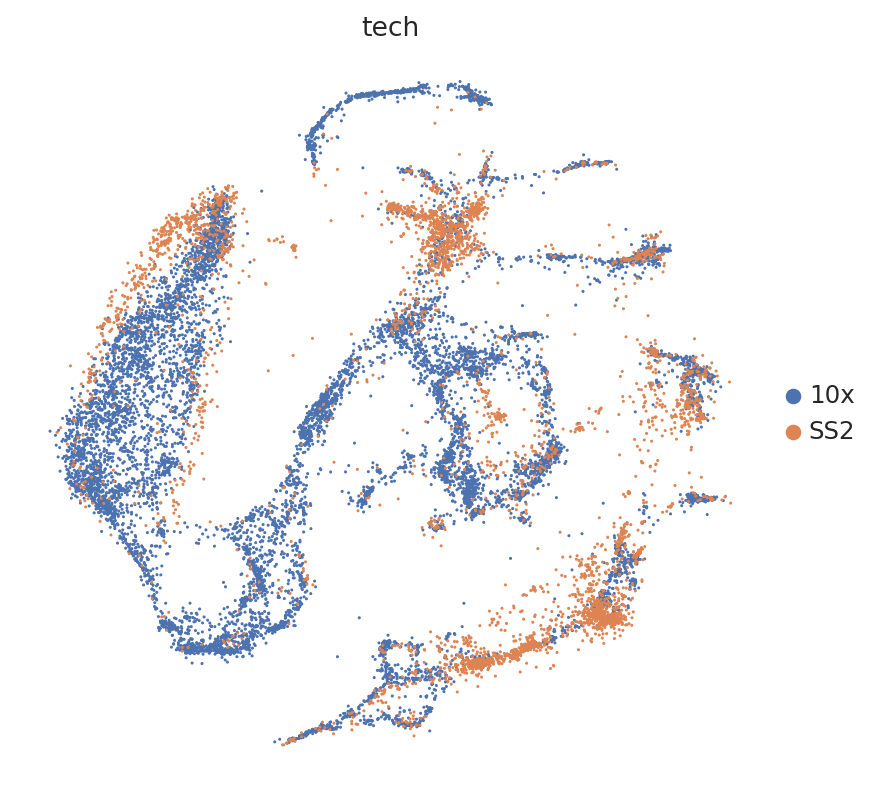

In [16]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["tech"],
    frameon=False,
    ncols=1,
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


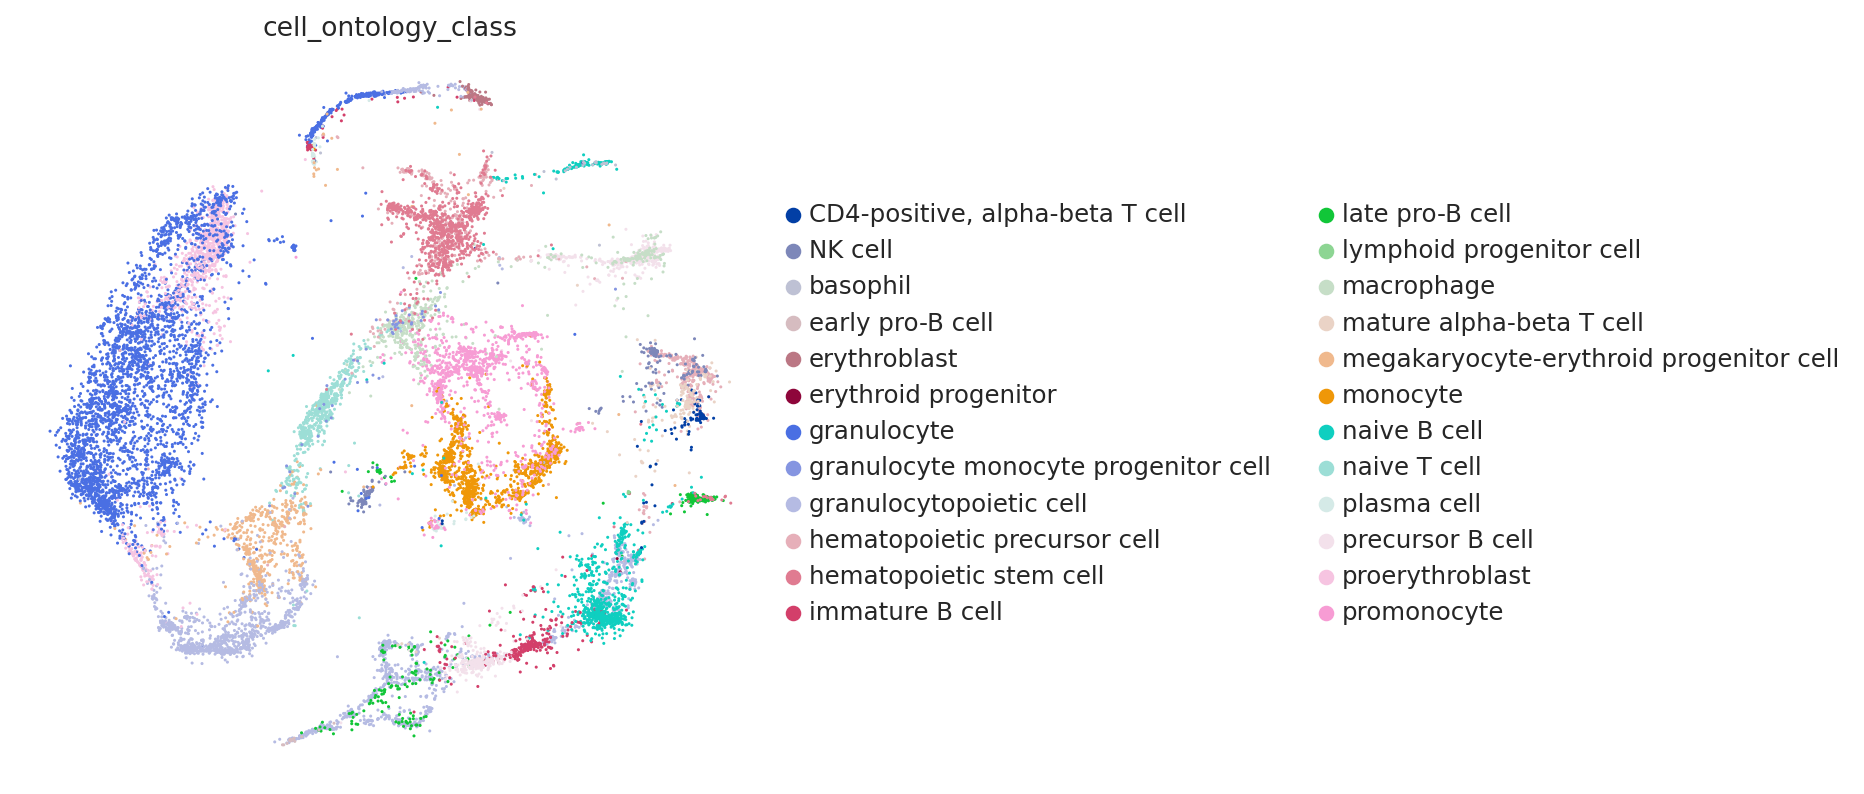

In [17]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis=SCVI_MDE_KEY)

From a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. A more refined analysis may be done at the level of markers.

## Transfer of annotations with scANVI

With scVI alone, we can train a classifier (e.g., [`RandomForestClassifer`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) on the latent representation of the labeled data and then obtain predictions for the query data. For example, we can imagine the 10x data is unannotated and then proceed to transfer labels using the latent reprsentation of the SS2 data.

We can also try to obtain a better latent representation/predictions by using the labels to inform the latent space. This is where scANVI comes in. scANVI uses semi-supervised learning to improve the model learned with scVI, allowing us to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to scANVI:

- the sample identifier for each cell (as in scVI), which in this case is the technology (10x vs SS2)
- the cell type, or an unnassigned label for each cell

#### scANVI labels

We assume that the SS2 data is annotated and the 10X data is not. Only the labels of the cells from the labelled SS2 dataset will be kept in the `adata.obs` column `'celltype_scanvi'`. All the 10X cells will have `'celltype_scanvi'` of value 'Unknown'.

In [18]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ss2_mask = adata.obs["tech"] == "SS2"
adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[
    ss2_mask
].values

/tmp/ipykernel_158/2464218978.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[
/tmp/ipykernel_158/2464218978.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [19]:
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

(array(['CD4-positive, alpha-beta T cell', 'NK cell', 'Unknown',
        'basophil', 'early pro-B cell', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic stem cell', 'immature B cell', 'late pro-B cell',
        'lymphoid progenitor cell', 'macrophage',
        'mature alpha-beta T cell',
        'megakaryocyte-erythroid progenitor cell', 'naive B cell',
        'precursor B cell', 'promonocyte'], dtype=object),
 array([  107,   139, 11707,    26,    24,   773,    52,    67,   894,
          281,   132,    13,   136,   150,    22,   740,   321,   323]))

Since we've already trained an scVI model on our data, we will use it as a pretrained model to scANVI.

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [21]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   5%|▌         | 1/20 [00:01<00:30,  1.61s/it]

Epoch 1/20:   5%|▌         | 1/20 [00:01<00:30,  1.61s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.09e+3]

Epoch 2/20:   5%|▌         | 1/20 [00:01<00:30,  1.61s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.09e+3]

Epoch 2/20:  10%|█         | 2/20 [00:03<00:28,  1.61s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.09e+3]

Epoch 2/20:  10%|█         | 2/20 [00:03<00:28,  1.61s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 3/20:  10%|█         | 2/20 [00:03<00:28,  1.61s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 3/20:  15%|█▌        | 3/20 [00:04<00:27,  1.61s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.05e+3]

Epoch 3/20:  15%|█▌        | 3/20 [00:04<00:27,  1.61s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.04e+3]

Epoch 4/20:  15%|█▌        | 3/20 [00:04<00:27,  1.61s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.04e+3]

Epoch 4/20:  20%|██        | 4/20 [00:06<00:25,  1.61s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.04e+3]

Epoch 4/20:  20%|██        | 4/20 [00:06<00:25,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 5/20:  20%|██        | 4/20 [00:06<00:25,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 5/20:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 5/20:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 6/20:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 6/20:  30%|███       | 6/20 [00:09<00:22,  1.62s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.04e+3]

Epoch 6/20:  30%|███       | 6/20 [00:09<00:22,  1.62s/it, v_num=1, train_loss_step=953, train_loss_epoch=1.03e+3]    

Epoch 7/20:  30%|███       | 6/20 [00:09<00:22,  1.62s/it, v_num=1, train_loss_step=953, train_loss_epoch=1.03e+3]

Epoch 7/20:  35%|███▌      | 7/20 [00:11<00:20,  1.61s/it, v_num=1, train_loss_step=953, train_loss_epoch=1.03e+3]

Epoch 7/20:  35%|███▌      | 7/20 [00:11<00:20,  1.61s/it, v_num=1, train_loss_step=935, train_loss_epoch=1.03e+3]

Epoch 8/20:  35%|███▌      | 7/20 [00:11<00:20,  1.61s/it, v_num=1, train_loss_step=935, train_loss_epoch=1.03e+3]

Epoch 8/20:  40%|████      | 8/20 [00:12<00:19,  1.61s/it, v_num=1, train_loss_step=935, train_loss_epoch=1.03e+3]

Epoch 8/20:  40%|████      | 8/20 [00:12<00:19,  1.61s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.03e+3]

Epoch 9/20:  40%|████      | 8/20 [00:12<00:19,  1.61s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.03e+3]

Epoch 9/20:  45%|████▌     | 9/20 [00:14<00:17,  1.61s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.03e+3]

Epoch 9/20:  45%|████▌     | 9/20 [00:14<00:17,  1.61s/it, v_num=1, train_loss_step=955, train_loss_epoch=1.03e+3]    

Epoch 10/20:  45%|████▌     | 9/20 [00:14<00:17,  1.61s/it, v_num=1, train_loss_step=955, train_loss_epoch=1.03e+3]

Epoch 10/20:  50%|█████     | 10/20 [00:16<00:16,  1.60s/it, v_num=1, train_loss_step=955, train_loss_epoch=1.03e+3]

Epoch 10/20:  50%|█████     | 10/20 [00:16<00:16,  1.60s/it, v_num=1, train_loss_step=905, train_loss_epoch=1.03e+3]

Epoch 11/20:  50%|█████     | 10/20 [00:16<00:16,  1.60s/it, v_num=1, train_loss_step=905, train_loss_epoch=1.03e+3]

Epoch 11/20:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it, v_num=1, train_loss_step=905, train_loss_epoch=1.03e+3]

Epoch 11/20:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.03e+3]

Epoch 12/20:  55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.03e+3]

Epoch 12/20:  60%|██████    | 12/20 [00:19<00:12,  1.61s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.03e+3]

Epoch 12/20:  60%|██████    | 12/20 [00:19<00:12,  1.61s/it, v_num=1, train_loss_step=957, train_loss_epoch=1.03e+3]    

Epoch 13/20:  60%|██████    | 12/20 [00:19<00:12,  1.61s/it, v_num=1, train_loss_step=957, train_loss_epoch=1.03e+3]

Epoch 13/20:  65%|██████▌   | 13/20 [00:20<00:11,  1.60s/it, v_num=1, train_loss_step=957, train_loss_epoch=1.03e+3]

Epoch 13/20:  65%|██████▌   | 13/20 [00:20<00:11,  1.60s/it, v_num=1, train_loss_step=912, train_loss_epoch=1.03e+3]

Epoch 14/20:  65%|██████▌   | 13/20 [00:20<00:11,  1.60s/it, v_num=1, train_loss_step=912, train_loss_epoch=1.03e+3]

Epoch 14/20:  70%|███████   | 14/20 [00:22<00:09,  1.60s/it, v_num=1, train_loss_step=912, train_loss_epoch=1.03e+3]

Epoch 14/20:  70%|███████   | 14/20 [00:22<00:09,  1.60s/it, v_num=1, train_loss_step=924, train_loss_epoch=1.03e+3]

Epoch 15/20:  70%|███████   | 14/20 [00:22<00:09,  1.60s/it, v_num=1, train_loss_step=924, train_loss_epoch=1.03e+3]

Epoch 15/20:  75%|███████▌  | 15/20 [00:24<00:08,  1.60s/it, v_num=1, train_loss_step=924, train_loss_epoch=1.03e+3]

Epoch 15/20:  75%|███████▌  | 15/20 [00:24<00:08,  1.60s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 16/20:  75%|███████▌  | 15/20 [00:24<00:08,  1.60s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 16/20:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 16/20:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 17/20:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 17/20:  85%|████████▌ | 17/20 [00:27<00:04,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 17/20:  85%|████████▌ | 17/20 [00:27<00:04,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 18/20:  85%|████████▌ | 17/20 [00:27<00:04,  1.61s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 18/20:  90%|█████████ | 18/20 [00:28<00:03,  1.60s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.03e+3]

Epoch 18/20:  90%|█████████ | 18/20 [00:28<00:03,  1.60s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.03e+3]

Epoch 19/20:  90%|█████████ | 18/20 [00:28<00:03,  1.60s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.03e+3]

Epoch 19/20:  95%|█████████▌| 19/20 [00:30<00:01,  1.59s/it, v_num=1, train_loss_step=1.01e+3, train_loss_epoch=1.03e+3]

Epoch 19/20:  95%|█████████▌| 19/20 [00:30<00:01,  1.59s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.03e+3]    

Epoch 20/20:  95%|█████████▌| 19/20 [00:30<00:01,  1.59s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.03e+3]

Epoch 20/20: 100%|██████████| 20/20 [00:32<00:00,  1.59s/it, v_num=1, train_loss_step=999, train_loss_epoch=1.03e+3]

Epoch 20/20: 100%|██████████| 20/20 [00:32<00:00,  1.59s/it, v_num=1, train_loss_step=947, train_loss_epoch=1.03e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it, v_num=1, train_loss_step=947, train_loss_epoch=1.03e+3]

Now we can predict the missing cell types, and get the latent space

In [22]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

Again, we may visualize the latent space as well as the inferred labels

In [23]:
SCANVI_MDE_KEY = "X_mde_scanvi"
adata.obsm[SCANVI_MDE_KEY] = mde(adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

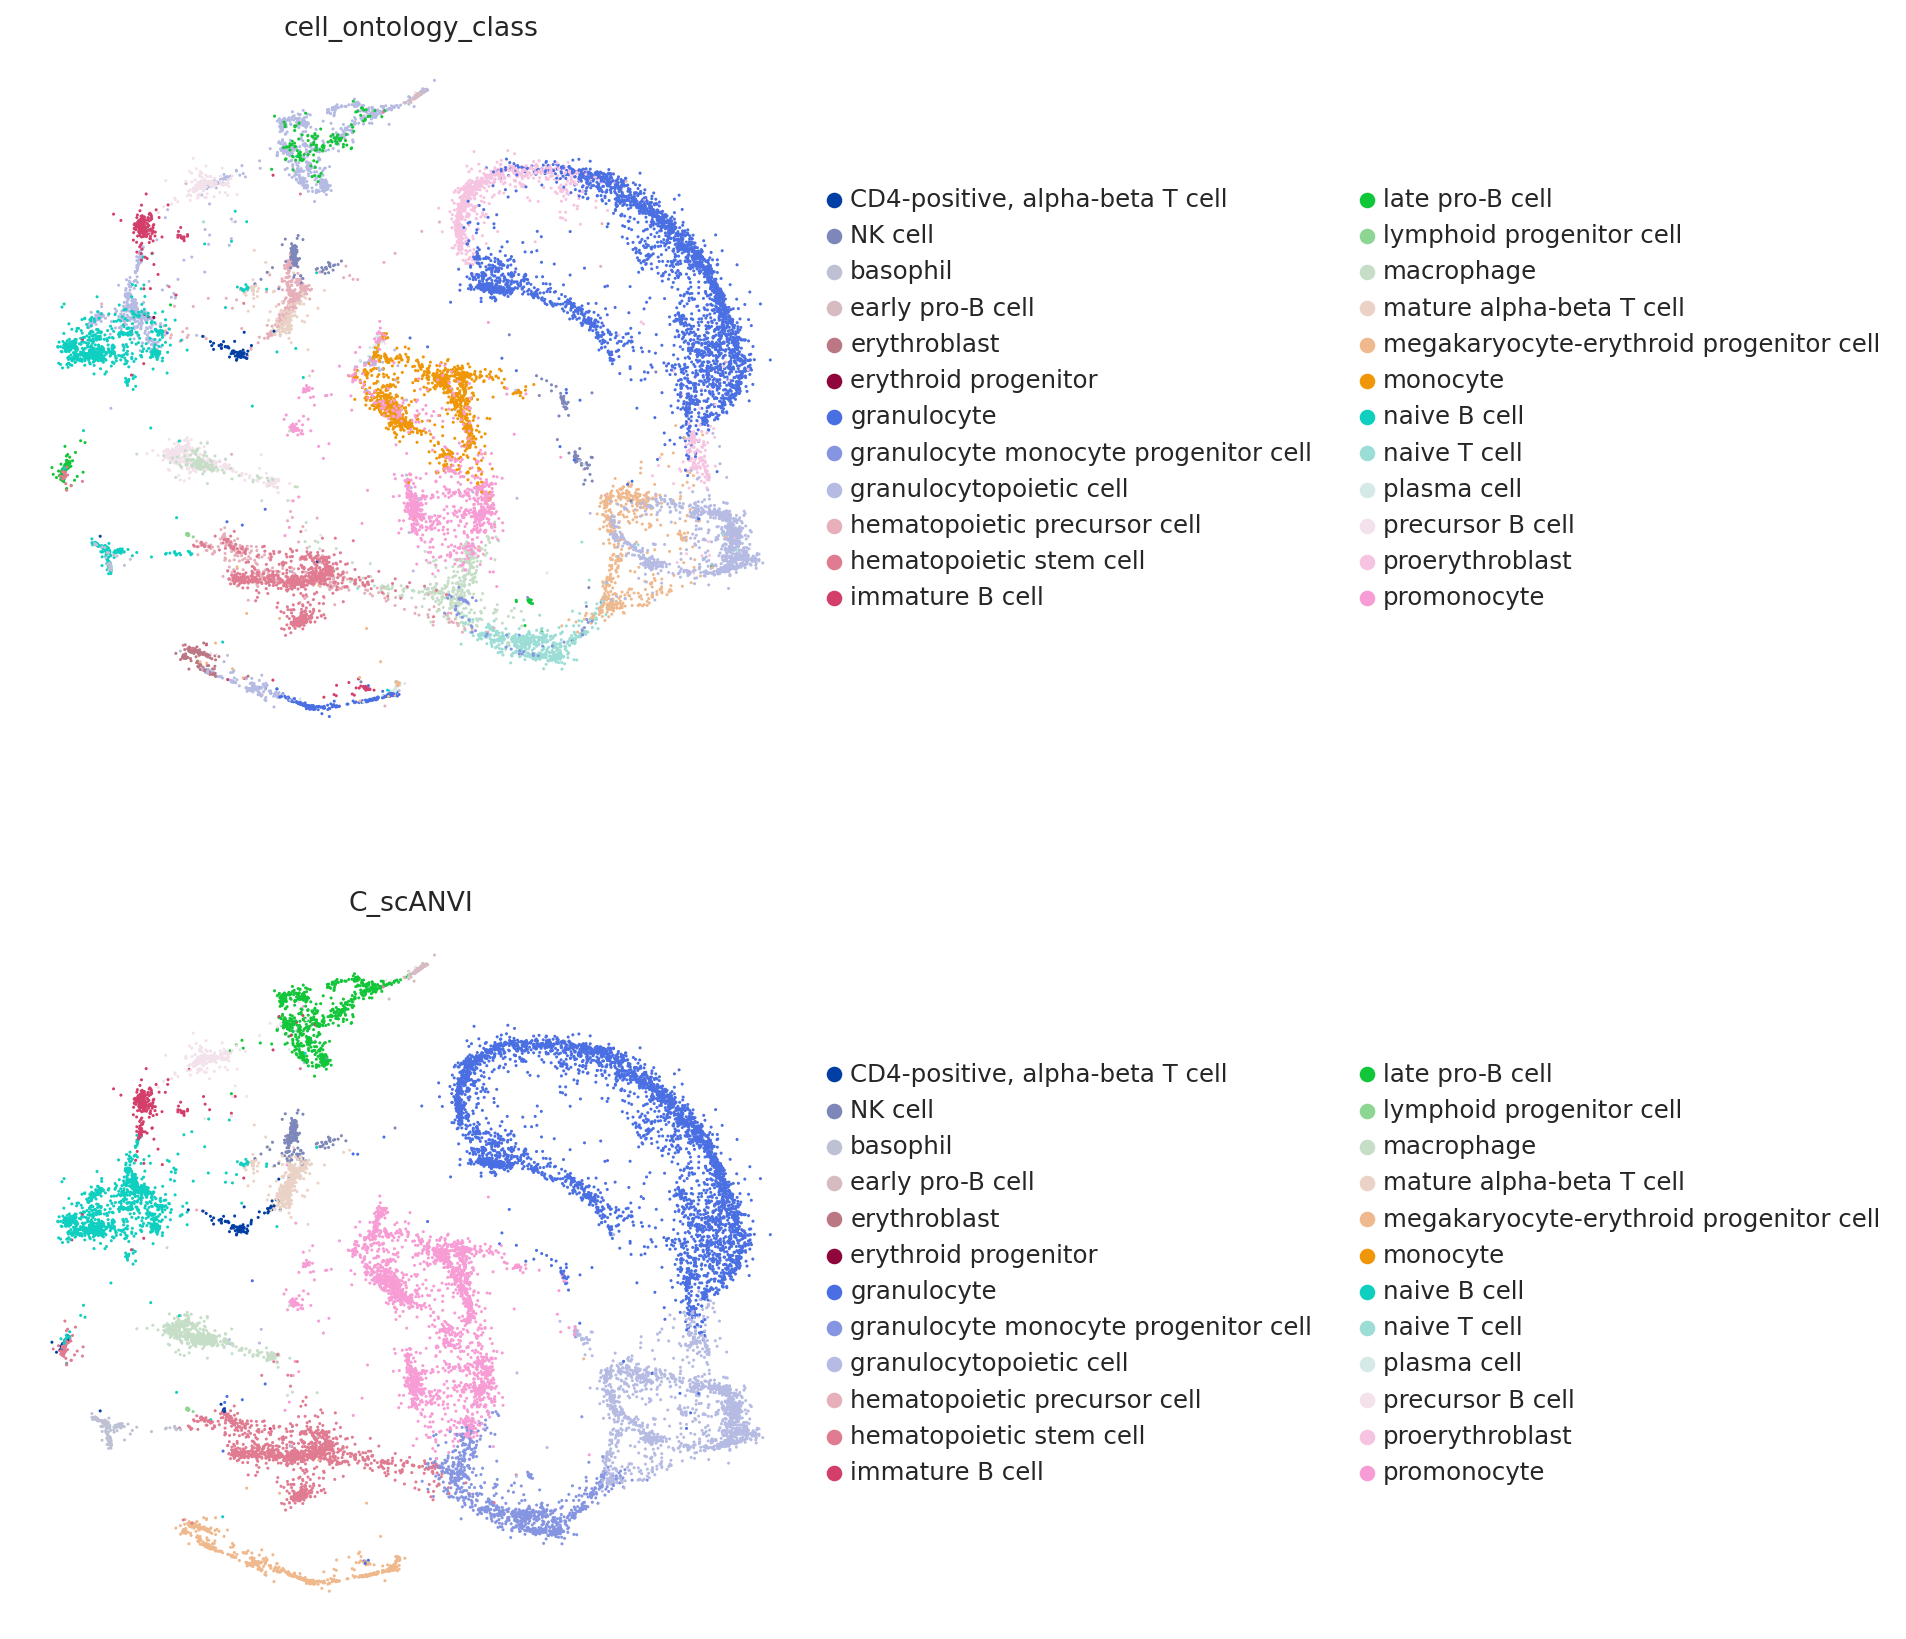

In [24]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories
)
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["cell_ontology_class", SCANVI_PREDICTION_KEY],
    ncols=1,
    frameon=False,
    palette=adata.uns["cell_ontology_class_colors"],
)

Now we can observe scANVI's performance using a confusion matrix.

In [25]:
df = (
    adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY])
    .size()
    .unstack(fill_value=0)
)

/tmp/ipykernel_158/963345604.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY])


In [26]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

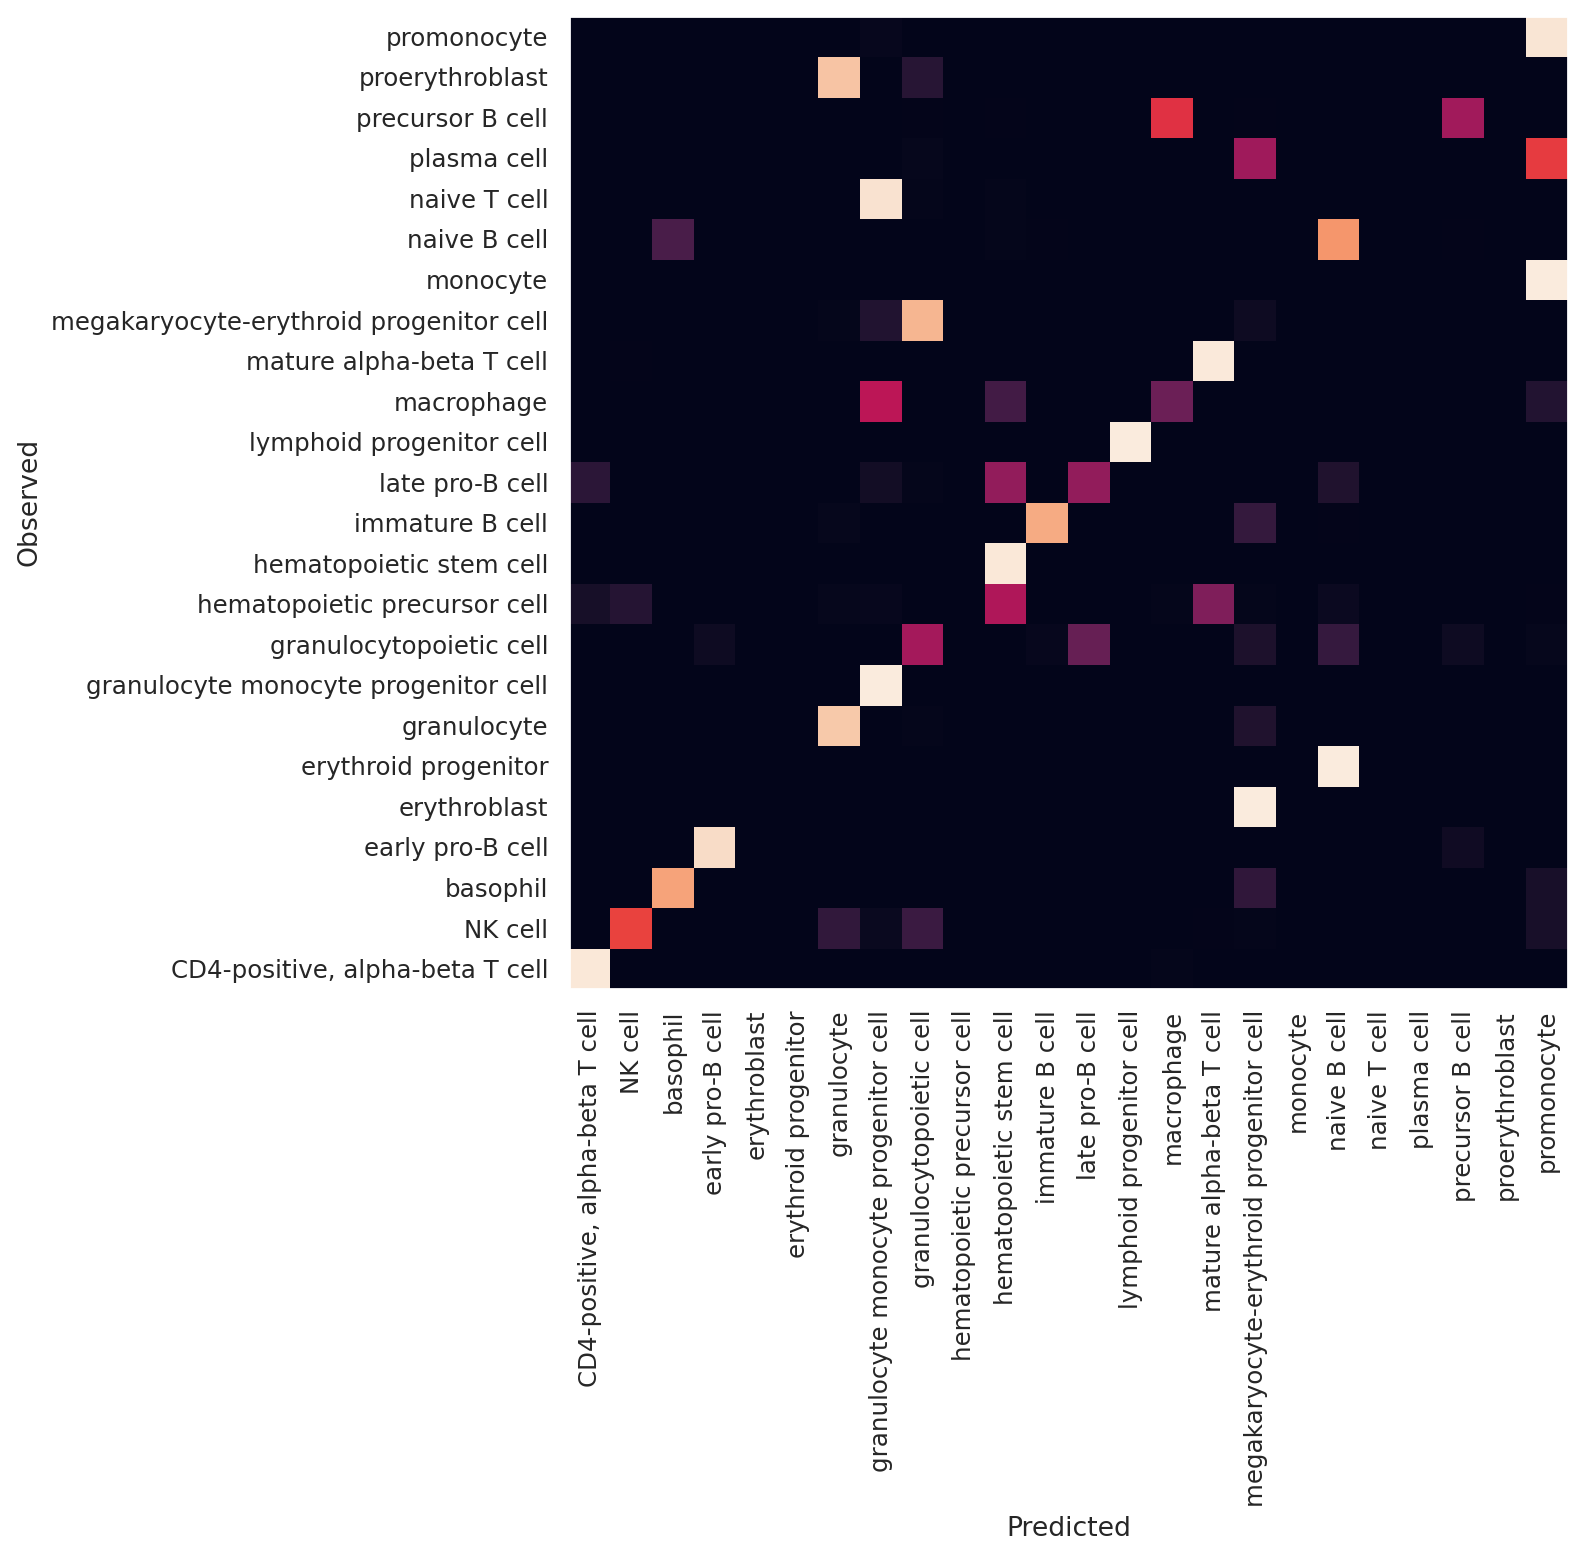

In [27]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However, biologically, the transferred labels are subsets of the original labels.